# 1. Vision Transformer Architecture

In [97]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from datetime import datetime
from gc import collect
from os import cpu_count
from scipy.io import savemat, loadmat
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/ViT architecture/working ViT")
sys.path.append(f"{os.getcwd()}/scripts/")
from VisionTransformer_working import VisionTransformer as Vit_old

sys.path.append(f"{os.getcwd()}/ViT architecture/Architecture tryouts/DPT/")
from VisionTransformer_working_for_DPT import VisionTransformer as Vit
from VisionTransformer_working_for_DPT import VisionTransformer3 as Vit3

In [98]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [99]:
collect()
torch.cuda.empty_cache()
torch.set_printoptions(precision=6)
device = torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


### 1. Comparison of model performances on in-distribution data

__Noise level:__ 0.005 * $\langle \sigma_{u}\rangle$

Load CNN and ViT model.

In [100]:
vit = Vit(dspl_size=104, 
              patch_size=8, 
              embed_dim=128,
              depth=6,
              n_heads=4,
              mlp_ratio=1.0,
              qkv_bias=False,
              p=0.1,
              attn_p=0.1,
              drop_path=0.).float()
path_to_vit_new = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/DPT/logs_and_weights/ViT-final_2023-Jul-27 16:26:18/ViT-final_2023-Jul-27 16:26:18.pth'
if torch.cuda.is_available():
    vit.load_state_dict(torch.load(path_to_vit_new)['best_model_weights'], strict=True)
else:
    vit.load_state_dict(torch.load(path_to_vit_new, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

In [84]:
cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/CNN_noisy_final-2023-May-18 23:46:36_checkpoint.h5')
#cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/CNN_noisy_final-2023-May-18 13:55:48_checkpoint.h5')

Load test data.

In [101]:
dspl_test = np.load('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm_new/data/test/displacements.npy')
trac_test = np.load('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm_new/data/test/tractions.npy')

In [102]:
#dspl_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Validation data/resolution_104/max5000/allDisplacements_final_max5000.h5', 'r')['dspl'])
#trac_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Validation data/resolution_104/max5000/allTractions_final_max5000.h5', 'r')['trac'])
#dspl_test = np.concatenate([dspl_test[i] for i in range(dspl_test.shape[0])], axis=0, dtype=np.float32)[:100]
#trac_test = np.concatenate([trac_test[i] for i in range(trac_test.shape[0])], axis=0, dtype=np.float32)[:100]

In [103]:
sigma = 0.005 * np.mean(np.var(dspl_test, axis=(1, 2, 3)))
cov = [[sigma, 0],[0, sigma]]
noise_0 = None
for i, x in tqdm(enumerate(dspl_test), desc='noised'):
    noise = np.random.default_rng().multivariate_normal(mean=[0, 0], cov=cov, size=(104, 104))
    if i == 0:
        noise_0 = noise
    dspl_test[i] = x + noise

noised: 100it [00:00, 1287.03it/s]


In [104]:
X_test = torch.from_numpy(np.moveaxis(dspl_test, 3, 1)).float()
Y_test = torch.from_numpy(np.moveaxis(trac_test, 3, 1)).float()

In [105]:
X_test.shape

torch.Size([100, 2, 104, 104])

Export the data to .mat files.

In [38]:
save_files_here = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data/Raw Samples'
xx, yy = np.meshgrid(np.arange(104), np.arange(104), indexing='ij')
pos = np.vstack([xx.reshape(-1), yy.reshape(-1)], dtype=np.double).T
path_to_dir = f'{save_files_here}/Gaussian_noise_1e-04'
os.makedirs(path_to_dir)
for j, sample in enumerate(X_test):
    file_name = f'{path_to_dir}/test_sample_{j + 1}.mat'
    vec_dspl = np.vstack([sample[0].reshape(-1), sample[1].reshape(-1)], dtype=np.double).T
    vec_noise = np.vstack([X_train_noise[j, 0].reshape(-1), X_train_noise[j, 1].reshape(-1)], dtype=np.double).T
    mdict = {'input_data': {'noise': [{'vec': vec_noise, 'pos': pos}, {'vec': vec_noise, 'pos': pos}], 'displacement': [{'vec': vec_dspl, 'pos': pos}, {'vec': vec_dspl, 'pos': pos}]}}
    savemat(file_name, mdict=mdict)

NameError: name 'X_train_noise' is not defined

Load predictions of the BFFTC method.

In [ ]:
bfftc_predictions = torch.zeros((100, 2, 102, 102))
bfftc_displacements = torch.zeros((100, 2, 102, 102))

directory = "/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data/Predictions/Gaussian_noise_1e-04"
    
for j, file in enumerate(os.listdir(f'{directory}')):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"):
        bfft_pred = loadmat(f'{directory}/pred_of_sample_{j + 1}')['TFM_results']['traction'][0][0].T.reshape((2, 102, 102), order='F')
        bfft_dspl = loadmat(f'{directory}/pred_of_sample_{j + 1}')['TFM_results']['displacement'][0][0].T.reshape((2, 102, 102), order='F')
        bfftc_predictions[j] = torch.tensor(bfft_pred)
        bfftc_displacements[j] = torch.tensor(bfft_dspl)

Allocate test samples to ground truths as they got mixed up when BFFTC was performed.

In [ ]:
bfftc_predictions_trimmed = torch.zeros((100, 2, 98, 98))
Y_test_trimmed = torch.zeros((100, 3, 98, 98))
X_test_trimmed = torch.zeros((100, 2, 98, 98))

for i, sample in enumerate(bfftc_displacements):
    for j, dspl in enumerate(X_test):
        if torch.allclose(dspl[:, 1:103, 1:103].float(), torch.tensor(sample).float(), atol=1e-02, rtol=1):
            print(f'bfftc dspl {i} matches dspl {j}')
            bfftc_predictions_trimmed[i] = torch.tensor(bfftc_predictions[i, :, 3:101, 3:101]).float()
            Y_test_trimmed[i] = Y_test[j, :, 3:101, 3:101].float()
            X_test_trimmed[i] = dspl[:, 3:101, 3:101].float()

Calculate CNN and ViT prediction on test set.

For test data:

In [106]:
vit.eval()
vit_predictions = vit(X_test)
#cnn_predictions = cnn.predict(np.moveaxis(np.array(X_test), 1, 3))

In [107]:
mse = torch.nn.MSELoss(reduction='none')
vit_mse = torch.mean(mse(vit_predictions[:, 0:2, 3:101, 3:101], Y_test[:, 0:2, 3:101, 3:101]), (1,2,3))
#cnn_mse = torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions, 3, 1)[:, :, 3:101, 3:101]), Y_test[:, 0:2, 3:101, 3:101]), (1,2,3))
#bfftc_mse = torch.mean(mse(bfftc_predictions[:, :, 3:101, 3:101], Y_test[:, 0:2, 3:101, 3:101]), (1,2,3))

In [108]:
torch.mean(vit_mse)

tensor(2.008026e-05, grad_fn=<MeanBackward0>)

In [109]:
trac_test.shape

(100, 104, 104, 2)

In [110]:
np.max(np.sqrt((trac_test[0, :, :, 0] ** 2 + trac_test[0, :, :, 1] ** 2)))

0.48502924704140543

In [111]:
torch.max(torch.sqrt((vit_predictions[0, 0, :, :] ** 2 + vit_predictions[0, 1, :, :] ** 2)))

tensor(0.489989, grad_fn=<MaxBackward1>)

In [94]:
torch.mean(cnn_mse)

NameError: name 'cnn_mse' is not defined

In [95]:
torch.mean(vit_mse) / torch.mean(cnn_mse)

NameError: name 'cnn_mse' is not defined

Text(0.5, 1.0, 'ViT: ML-prediction, loss:  0.000019')

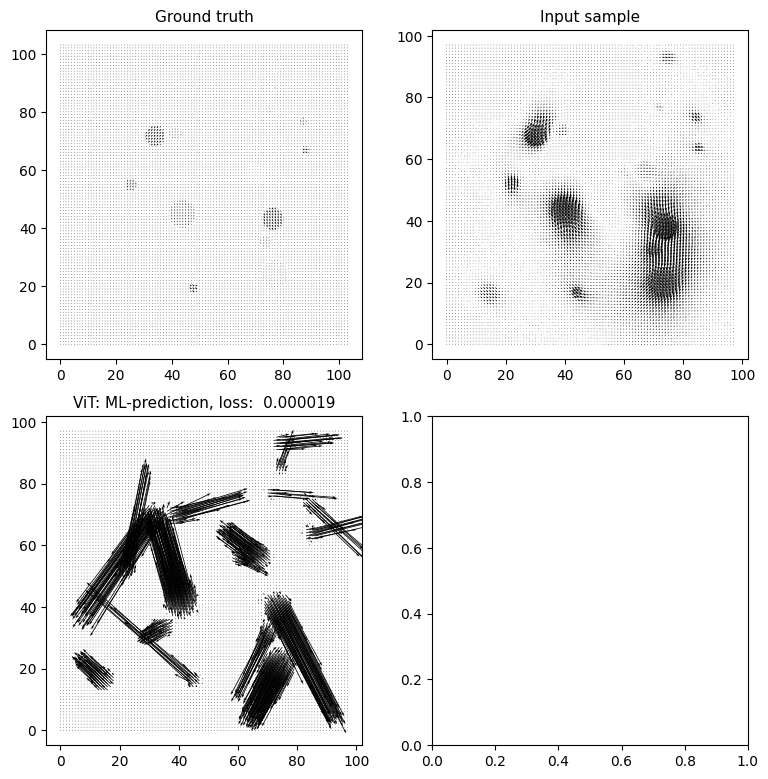

In [112]:
get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(Y_test[60, 0, :, :].detach().numpy(), Y_test[60, 1, :, :].detach().numpy(), scale=50)
axs[0, 0].set_title('Ground truth', {'fontsize': 11})

axs[0, 1].quiver(X_test[60, 0, 3:101, 3:101].detach().numpy(), X_test[60, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[0, 1].set_title(f'Input sample', {'fontsize': 11})

axs[1, 0].quiver(vit_predictions[60, 0, 3:101, 3:101].detach().numpy(), vit_predictions[60, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[1, 0].set_title(f'ViT: ML-prediction, loss: {vit_mse[2]:9.6f}', {'fontsize': 11})

#axs[1, 1].quiver(cnn_predictions[2, 3:101, 3:101, 0], cnn_predictions[2, 3:101, 3:101, 1], scale=1)
#axs[1, 1].set_title(f'CNN: point-prediction, loss: {cnn_mse[2]:9.6f}', {'fontsize': 11})

Load real cells 

In [27]:
real_displacements = torch.zeros((10, 2, 104, 104))

directory = "/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/DL-TFM-main/cells/cells/dspl"
    
for j, file in enumerate(os.listdir(f'{directory}')):
    if j == 10:
        break
    filename = os.fsdecode(file)
    print(filename)
    if filename.endswith(".mat"):
        dspl = loadmat(f'{directory}/MLData00{j + 1}')['dspl']
        real_displacements[j] = torch.tensor(np.moveaxis(dspl, 2, 0))

MLData001.mat
MLData006.mat
MLData007.mat
MLData005.mat
MLData010.mat
MLData013.mat
MLData004.mat
MLData011.mat
MLData012.mat
MLData009.mat


FileNotFoundError: [Errno 2] No such file or directory: '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/DL-TFM-main/cells/cells/dspl/MLData0010.mat'

In [28]:
real_displacements.shape

torch.Size([10, 2, 104, 104])

<IPython.core.display.Javascript object>


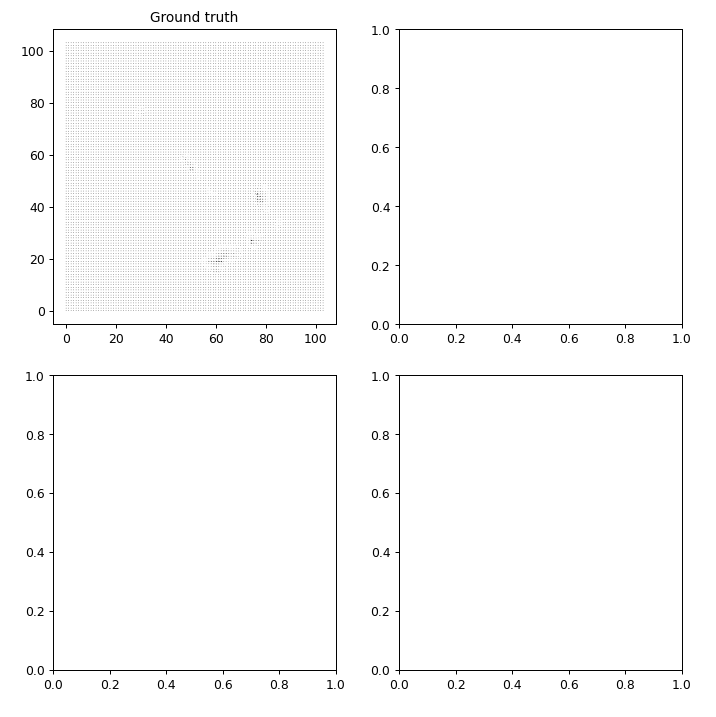

NameError: name 'X_test' is not defined

In [29]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(real_displacements[0, 0, :, :].detach().numpy(), real_displacements[0, 1, :, :].detach().numpy(), scale=200.2)
axs[0, 0].set_title('Ground truth', {'fontsize': 11})

axs[0, 1].quiver(X_test[2, 0, 3:101, 3:101].detach().numpy(), X_test[2, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[0, 1].set_title(f'Input sample', {'fontsize': 11})

axs[1, 0].quiver(vit_predictions[2, 0, 3:101, 3:101].detach().numpy(), vit_predictions[2, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[1, 0].set_title(f'ViT: ML-prediction, loss: {vit_mse[2]:9.6f}', {'fontsize': 11})

axs[1, 1].quiver(cnn_predictions[2, 3:101, 3:101, 0], cnn_predictions[2, 3:101, 3:101, 1], scale=1)
axs[1, 1].set_title(f'CNN: point-prediction, loss: {cnn_mse[2]:9.6f}', {'fontsize': 11})

Preprocess real cells

In [30]:
save_files_here = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/real_cells/Raw Samples'
xx, yy = np.meshgrid(np.arange(104), np.arange(104), indexing='ij')
pos = np.vstack([xx.reshape(-1), yy.reshape(-1)], dtype=np.double).T
for j, sample in enumerate(real_displacements):
    file_name = f'{save_files_here}/test_sample_{j + 1}.mat'
    vec_dspl = np.vstack([sample[0].reshape(-1), sample[1].reshape(-1)], dtype=np.double).T
    vec_noise = np.vstack([sample[0].reshape(-1), sample[1].reshape(-1)], dtype=np.double).T
    mdict = {'input_data': {'noise': [{'vec': vec_noise, 'pos': pos}, {'vec': vec_noise, 'pos': pos}], 'displacement': [{'vec': vec_dspl, 'pos': pos}, {'vec': vec_dspl, 'pos': pos}]}}
    savemat(file_name, mdict=mdict)

In [345]:
vit = Vit3(dspl_size=104, 
              patch_size=8, 
              embed_dim=128,
              depth=4,
              n_heads=4,
              mlp_ratio=1.0,
              p=0.05,
              attn_p=0.05,
              drop_path=0.).float()
path_to_vit_new = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/DPT/logs_and_weights/ViT-GNLL_final2023-May-17 23:02:08/ViT-GNLL_final2023-May-17 23:02:08.pth'
if torch.cuda.is_available():
    vit.load_state_dict(torch.load(path_to_vit_new)['best_model_weights'], strict=True)
else:
    vit.load_state_dict(torch.load(path_to_vit_new, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

In [346]:
vit.eval()
vit_predictions = vit(X_test)
cnn_predictions = cnn.predict(np.moveaxis(np.array(X_test), 1, 3))

2/2 [==============================] - 0s 30ms/step


In [347]:
mse = torch.nn.MSELoss(reduction='none')
vit_mse = torch.mean(mse(vit_predictions[:, 0:2, 3:101, 3:101], Y_test[:, 0:2, 3:101, 3:101]), (1,2,3))
cnn_mse = torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions, 3, 1)[:, :, 3:101, 3:101]), Y_test[:, 0:2, 3:101, 3:101]), (1,2,3))
#bfftc_mse = torch.mean(mse(bfftc_predictions[:, :, 3:101, 3:101], Y_test[:, 0:2, 3:101, 3:101]), (1,2,3))

In [332]:
def inference_with_dropout(model, inputs):
    model.eval()
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()
    return model(inputs)

In [375]:
n_forward_passes = 50

predictions_vit = torch.zeros(10, 50, 4, 104, 104)
errors_vit = torch.zeros(10, 50, 2, 104, 104)
#predictions_cnn = torch.zeros(5, 50, 2, 104, 104)
for i in range(0, len(X_test[0:10])):
    for j in range(0, n_forward_passes):
        predictions_vit[i, j, :, :, :] = inference_with_dropout(vit, X_test[i][np.newaxis, ...])
        errors_vit[i, j, :, :, :] = mse(predictions_vit[i, j, 0:2, :, :], Y_test[i, 0:2])
        #predictions_cnn[i, j, :, :, :] = torch.tensor(np.moveaxis(np.array((cnn_(dspl[i][np.newaxis, ...]))), 3, 1))

In [376]:
predicted_means = (1 / 50) * torch.sum(predictions_vit[:, :, 0:2], dim=1)
predicted_vars = (1 / 50) * (torch.sum(predictions_vit[:, :, 0:2] + predictions_vit[:, :, 2:], dim=1)) - predicted_means
epistemic_vars = predicted_vars - (1 / 50) * torch.sum(predictions_vit[:, :, 2:], dim=1)
aleatoric_vars = predicted_vars - epistemic_vars

In [377]:
torch.mean(predicted_vars, dim=(1,2,3))

tensor([0.000501, 0.000314, 0.000303, 0.000367, 0.000436, 0.000496, 0.000540,
        0.000458, 0.000668, 0.000775], grad_fn=<MeanBackward1>)

In [378]:
errors = torch.mean(errors_vit, dim=1)

In [393]:
def uceloss(errors, uncert, n_bins=15, outlier=0.0, range=None):
    device = errors.device
    if range == None:
        bin_boundaries = torch.linspace(uncert.min().item(), uncert.max().item(), n_bins + 1, device=device)
    else:
        bin_boundaries = torch.linspace(range[0], range[1], n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    print(list(zip(bin_lowers, bin_uppers)))

    errors_in_bin_list = []
    avg_uncert_in_bin_list = []
    prop_in_bin_list = []

    uce = torch.zeros(1, device=device)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |uncertainty - error| in each bin
        in_bin = uncert.gt(bin_lower.item()) * uncert.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()  # |Bm| / n
        prop_in_bin_list.append(prop_in_bin)
        if prop_in_bin.item() > outlier:
            errors_in_bin = errors[in_bin].float().mean()  # err()
            avg_uncert_in_bin = uncert[in_bin].mean()  # uncert()
            uce += torch.abs(avg_uncert_in_bin - errors_in_bin) * prop_in_bin

            errors_in_bin_list.append(errors_in_bin)
            avg_uncert_in_bin_list.append(avg_uncert_in_bin)

    err_in_bin = torch.tensor(errors_in_bin_list, device=device)
    avg_uncert_in_bin = torch.tensor(avg_uncert_in_bin_list, device=device)
    prop_in_bin = torch.tensor(prop_in_bin_list, device=device)

    return uce, err_in_bin, avg_uncert_in_bin, prop_in_bin

In [394]:
uceloss(errors=errors, uncert=predicted_vars)

[(tensor(3.972673e-09), tensor(0.016332)), (tensor(0.016332), tensor(0.032665)), (tensor(0.032665), tensor(0.048997)), (tensor(0.048997), tensor(0.065329)), (tensor(0.065329), tensor(0.081661)), (tensor(0.081661), tensor(0.097994)), (tensor(0.097994), tensor(0.114326)), (tensor(0.114326), tensor(0.130658)), (tensor(0.130658), tensor(0.146990)), (tensor(0.146990), tensor(0.163323)), (tensor(0.163323), tensor(0.179655)), (tensor(0.179655), tensor(0.195987)), (tensor(0.195987), tensor(0.212320)), (tensor(0.212320), tensor(0.228652)), (tensor(0.228652), tensor(0.244984))]


(tensor([0.000182], grad_fn=<AddBackward0>),
 tensor([0.000172, 0.014875, 0.021393, 0.023230, 0.029671, 0.028608, 0.026145,
         0.045286, 0.070046, 0.012393, 0.031143]),
 tensor([2.448583e-04, 2.276469e-02, 3.943658e-02, 5.523600e-02, 7.180981e-02,
         8.738423e-02, 1.029319e-01, 1.228785e-01, 1.410467e-01, 1.519299e-01,
         2.449841e-01]),
 tensor([9.924279e-01, 5.126664e-03, 1.479290e-03, 5.269970e-04, 1.987796e-04,
         1.294379e-04, 5.547337e-05, 2.773669e-05, 9.245562e-06, 9.245562e-06,
         0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00, 4.622781e-06]))

In [341]:
from matplotlib import pyplot as plt
import numpy as np
import torch


def plot_uncert_multi(err_list, sigma_list, freq_in_bin_list=None, outlier_freq=0.0):
    assert len(err_list) == len(sigma_list)

    for i in range(len(err_list)):
        if freq_in_bin_list is not None:
            freq_in_bin_list[i] = freq_in_bin_list[i][
                torch.where(freq_in_bin_list[i] > outlier_freq)]  # filter out zero frequencies
            err_list[i] = err_list[i][torch.where(freq_in_bin_list[i] > outlier_freq)]
            sigma_list[i] = sigma_list[i][torch.where(freq_in_bin_list[i] > outlier_freq)]

    err = torch.stack(err_list).mean(dim=0)
    err_var = torch.stack(err_list).var(dim=0).sqrt()
    sigma = torch.stack(sigma_list).mean(dim=0)

    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.25))
    max_val = np.max([err.max(), sigma.max()])
    min_val = np.min([err.min(), sigma.min()])
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.plot(sigma, err, marker='.')
    ax.fill_between(sigma, err + err_var, err - err_var, alpha=0.5)
    ax.set_ylabel(r'error')
    ax.set_xlabel(r'uncertainty')
    ax.set_aspect(1)
    fig.tight_layout()
    return fig, ax

In [349]:
plot_uncert_multi(errors, predicted_vars)

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

<IPython.core.display.Javascript object>


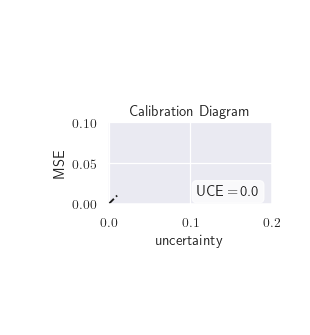

In [369]:
%matplotlib notebook
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{bm}']


fig, ax = plt.subplots(1, 1, figsize=(2.25, 2.25))

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax.plot([0, 0.01], [0, 0.01], 'k--')
ax.set_ylabel(r'MSE')
ax.set_xlabel(r'uncertainty')
ax.set_xlim([-0.001, 0.2])
ax.set_ylim([-0.001, 0.1])
ax.set_xticks([0, 0.1, 0.2])
ax.set_yticks([0, 0.05, 0.1])
ax.set_aspect(1)
#plt.plot(li[:])
ax.set_title(r'Calibration Diagram')
textstr0 = 'UCE\,=\,0.0'
ax.text(0.925, 0.075, textstr0, transform=ax.transAxes, fontsize=12,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=props
                )

#ax.annotate(r'BreastPathQ/EfficientNet-B4', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
#               xycoords=ax.yaxis.label, textcoords='offset points',
#               size='large', ha='right', va='center', fontsize=10, rotation=90)
fig.tight_layout()
fig.show()

fig.savefig(f"empty_calib_diagram.pdf", bbox_inches='tight', pad_inches=0.01)

In [360]:
li = list(zip(np.array(predicted_vars.detach()).flatten(), np.array(errors.detach()).flatten()))

In [361]:
li

[(0.13235238, 0.001842072),
 (0.092345126, 0.0058470126),
 (0.16163215, 0.0100462865),
 (0.11638562, 0.011095834),
 (0.08289131, 0.005096629),
 (0.0869601, 0.0043817777),
 (0.06709205, 0.0055301506),
 (0.07282554, 0.0050318153),
 (0.07745075, 0.0016283456),
 (0.07868991, 0.002993237),
 (0.1135784, 0.005187067),
 (0.080113135, 0.0041295793),
 (0.06455839, 0.0025664666),
 (0.07539719, 0.0061458824),
 (0.05400376, 0.004663367),
 (0.021323975, 0.0027118041),
 (0.0681548, 0.001591476),
 (0.06761808, 0.0032777002),
 (0.10318133, 0.0029263971),
 (0.13553178, 0.0026646883),
 (0.10607265, 0.002285026),
 (0.1494575, 0.0026668718),
 (0.091931075, 0.005922275),
 (0.020520627, 0.0066952533),
 (0.100082256, 0.0018354778),
 (0.0661581, 0.0058684987),
 (0.098106965, 0.011996541),
 (0.050983712, 0.01424771),
 (0.0502745, 0.0032269468),
 (0.07085543, 0.0052484544),
 (0.04544491, 0.007577935),
 (0.03195101, 0.011358313),
 (0.029946668, 0.0014540933),
 (0.024296636, 0.003981217),
 (0.040017333, 0.00592250

In [325]:
li.sort(key=lambda x: x[0])

<IPython.core.display.Javascript object>


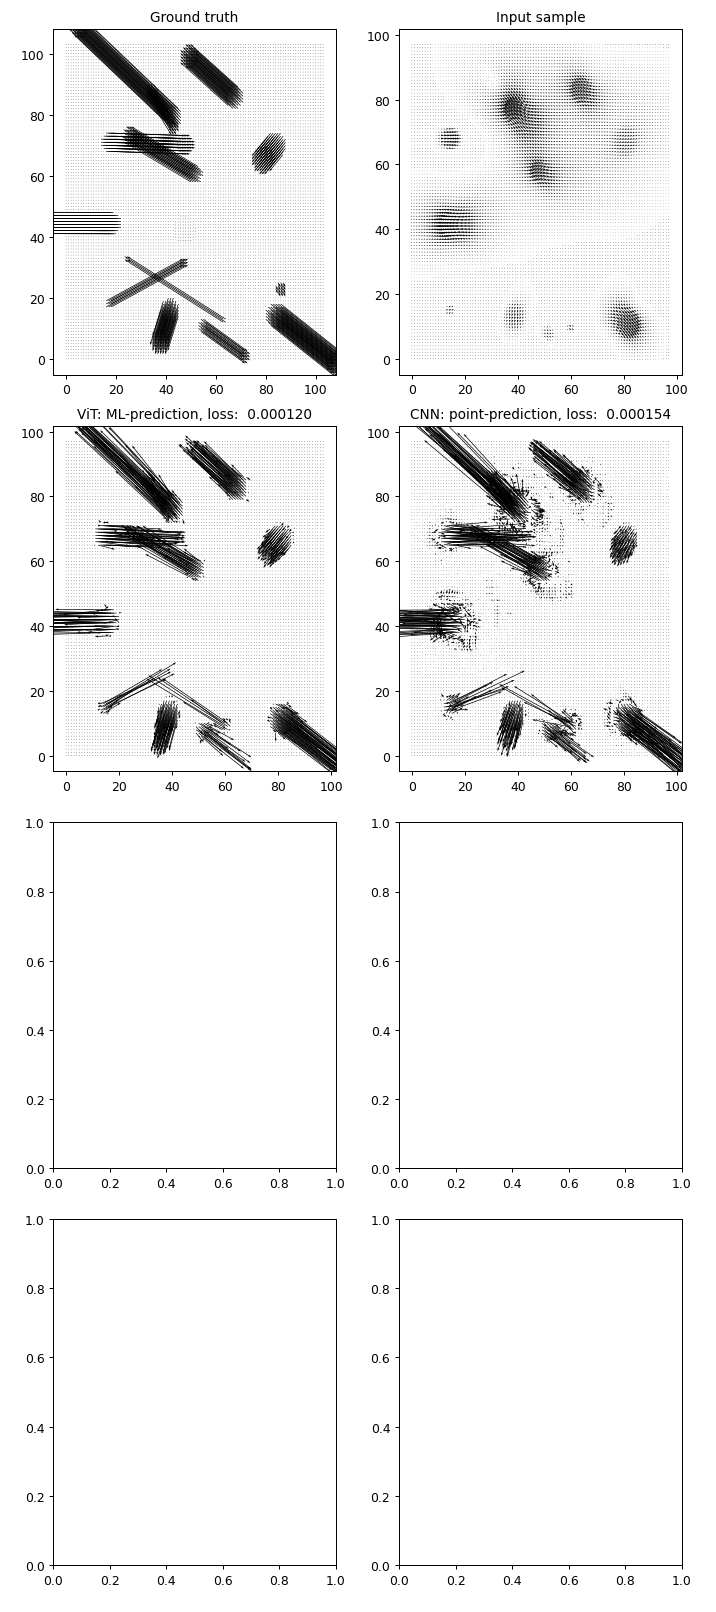

NameError: name 'predicted_means' is not defined

In [348]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(4, 2, figsize=(8, 18))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(Y_test[2, 0, :, :].detach().numpy(), Y_test[2, 1, :, :].detach().numpy(), scale=1)
axs[0, 0].set_title('Ground truth', {'fontsize': 11})

axs[0, 1].quiver(X_test[2, 0, 3:101, 3:101].detach().numpy(), X_test[2, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[0, 1].set_title(f'Input sample', {'fontsize': 11})

axs[1, 0].quiver(vit_predictions[2, 0, 3:101, 3:101].detach().numpy(), vit_predictions[2, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[1, 0].set_title(f'ViT: ML-prediction, loss: {vit_mse[2]:9.6f}', {'fontsize': 11})

axs[1, 1].quiver(cnn_predictions[2, 3:101, 3:101, 0], cnn_predictions[2, 3:101, 3:101, 1], scale=1)
axs[1, 1].set_title(f'CNN: point-prediction, loss: {cnn_mse[2]:9.6f}', {'fontsize': 11})

axs[2, 0].quiver(predicted_means[2, 0, 3:101, 3:101].detach().numpy(), predicted_means[2, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[2, 0].set_title(f'ViT: predictive mean, loss: {torch.mean(mse(predicted_means[2, :, 3:101, 3:101].unsqueeze(dim=0), Y_test[2, 0:2, 3:101, 3:101].unsqueeze(dim=0))):9.6f})', {'fontsize': 11})

C = np.sqrt(predicted_vars[2, 0, 3:101, 3:101].detach() **2 + predicted_vars[2, 1, 3:101, 3:101].detach() **2)
im = axs[2, 1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[2,1])
axs[2, 1].set_title(f'ViT: predictive variance', {'fontsize': 11})

C = np.sqrt(aleatoric_vars[2, 0, 3:101, 3:101].detach() **2 + aleatoric_vars[2, 1, 3:101, 3:101].detach() **2)
im = axs[3, 0].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[3,0])
axs[3, 0].set_title(f'ViT: aleatoric variance', {'fontsize': 11})

C = np.sqrt(epistemic_vars[2, 0, 3:101, 3:101].detach() **2 + epistemic_vars[2, 1, 3:101, 3:101].detach() **2)
im = axs[3, 1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[3,1])
axs[3, 1].set_title(f'ViT: epistemic variance', {'fontsize': 11})

<IPython.core.display.Javascript object>


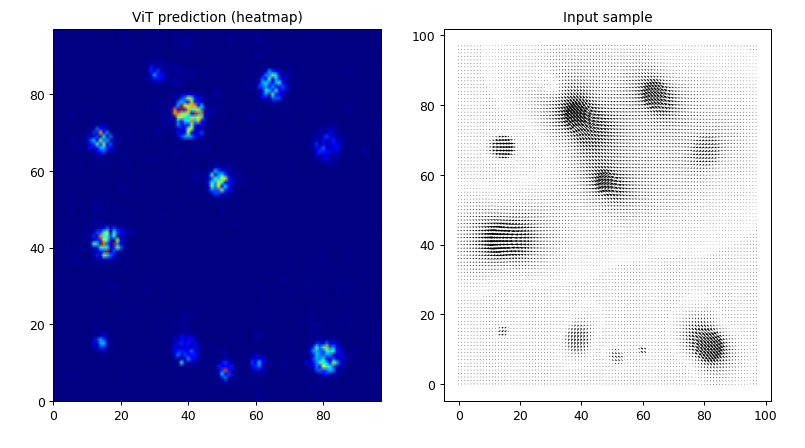

Text(0.5, 1.0, 'Input sample')

In [202]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

C = np.sqrt(epistemic_vars[2, 0, 3:101, 3:101].detach().numpy() **2 + epistemic_vars[2, 1, 3:101, 3:101].detach().numpy() ** 2)
axs[0].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0].set_title('ViT prediction (heatmap)', {'fontsize': 11})

axs[1].quiver(X_test[2, 0, 3:101, 3:101].detach().numpy(), X_test[2, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[1].set_title(f'Input sample', {'fontsize': 11})

### Prediction on Wang & Lin cells

In [110]:
real_cells = []
real_dspl = torch.zeros((14, 2, 104, 104))
directory = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/DL-TFM-main/cells/cells/dspl'

for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"):
        real_cell = {}
        file = loadmat(directory+'/'+filename)
        real_cell['brdx'] = np.rot90(file['brdx'], 2)
        real_cell['brdy'] = np.rot90(file['brdy'], 2)
        real_cell['dspl'] = torch.tensor((1 / 200.2) * np.moveaxis(file['dspl'], 2, 0))
        real_cell['vit_pred'] = vit(real_cell['dspl'].unsqueeze(0).float())
        real_cell['cnn_pred'] = cnn.predict(np.expand_dims(np.moveaxis(np.array(real_cell['dspl']), 0, 2), 0))
        real_cells.append(real_cell)

1/1 [==============================] - 0s 19ms/step


In [36]:
cnn_pred_real = np.moveaxis(np.array(real_dspl), 0, 2)

In [111]:
real_cells[0]['cnn_pred'].shape

(1, 104, 104, 2)

<IPython.core.display.Javascript object>


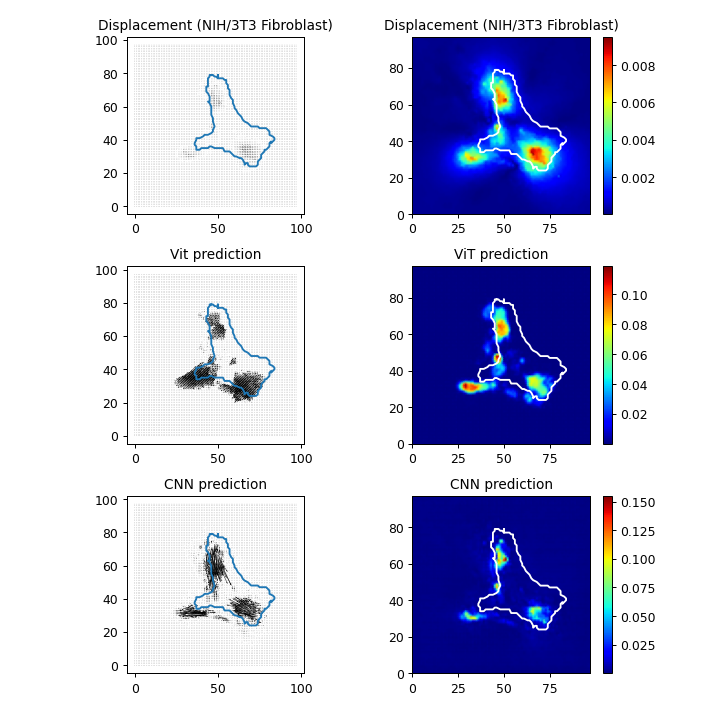

In [180]:
get_ipython().run_line_magic('matplotlib', 'notebook')
import matplotlib

fig, axs = plt.subplots(3, 2, figsize=(13, 25))
fig.tight_layout(pad=9, w_pad=2, h_pad=11)
                 
axs[0, 0].quiver(real_cells[1]['dspl'][0, 3:101, 3:101].detach().T, real_cells[1]['dspl'][1, 3:101, 3:101].detach().T, scale=1)
axs[0, 0].set_title(f'Displacement (NIH/3T3 Fibroblast)', {'fontsize': 11})
axs[0, 0].plot(real_cells[1]['brdx'][0], real_cells[1]['brdy'][0])
axs[0, 0].set_aspect('equal')

C = np.sqrt(real_cells[1]['dspl'][0, 3:101, 3:101].detach().T **2 + real_cells[1]['dspl'][1, 3:101, 3:101].detach().T ** 2)
im = axs[0, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0, 1].set_title(f'Displacement (NIH/3T3 Fibroblast)', {'fontsize': 11})
axs[0, 1].plot(real_cells[1]['brdx'][0], real_cells[1]['brdy'][0], c='white')
fig.colorbar(im, ax=axs[0,1])
fig.set_size_inches([8, 8],forward=True)
axs[0, 1].set_aspect('equal')

axs[1, 0].quiver(real_cells[1]['vit_pred'][0, 0, 3:101, 3:101].detach().numpy().T, real_cells[1]['vit_pred'][0, 0, 3:101, 3:101].detach().numpy().T, scale=1)
axs[1, 0].set_title(f'Vit prediction', {'fontsize': 11})
axs[1, 0].plot(real_cells[1]['brdx'][0], real_cells[1]['brdy'][0])
axs[1, 0].set_aspect('equal')

C = np.sqrt(real_cells[1]['vit_pred'][0, 0, 3:101, 3:101].detach().numpy().T **2 + real_cells[1]['vit_pred'][0, 1, 3:101, 3:101].detach().numpy().T ** 2)
im = axs[1, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1, 1].set_title(f'ViT prediction', {'fontsize': 11})
axs[1, 1].plot(real_cells[1]['brdx'][0], real_cells[1]['brdy'][0], c='white')
fig.colorbar(im, ax=axs[1,1])
fig.set_size_inches([8, 8],forward=True)
axs[1, 1].set_aspect('equal')

axs[2, 0].quiver(real_cells[1]['cnn_pred'][0, 3:101, 3:101, 0].T, real_cells[1]['cnn_pred'][0, 3:101, 3:101, 1].T, scale=1)
axs[2, 0].set_title(f'CNN prediction', {'fontsize': 11})
axs[2, 0].plot(real_cells[1]['brdx'][0], real_cells[1]['brdy'][0])
axs[2, 0].set_aspect('equal')

C = np.sqrt(real_cells[1]['cnn_pred'][0, 3:101, 3:101, 0].T **2 + real_cells[1]['cnn_pred'][0, 3:101, 3:101, 1].T ** 2)
im = axs[2, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[2, 1].set_title(f'CNN prediction', {'fontsize': 11})
axs[2, 1].plot(real_cells[1]['brdx'][0], real_cells[1]['brdy'][0], c='white')
fig.colorbar(im, ax=axs[2,1])
fig.set_size_inches([8, 8],forward=True)
axs[2, 1].set_aspect('equal')

Export experimental cells to MATLAB.

In [184]:
save_files_here = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/real_cells/raw data/1'
xx, yy = np.meshgrid(np.arange(104), np.arange(104), indexing='ij')
pos = np.vstack([xx.reshape(-1), yy.reshape(-1)], dtype=np.double).T
path_to_dir = f'{save_files_here}'
os.makedirs(path_to_dir)
for j, sample in enumerate(real_dspl):
    file_name = f'{path_to_dir}/test_sample_{j + 1}.mat'
    vec_dspl = np.vstack([sample[0].reshape(-1), sample[1].reshape(-1)], dtype=np.double).T
    vec_noise = vec_dspl
    mdict = {'input_data': {'noise': [{'vec': vec_noise, 'pos': pos}, {'vec': vec_noise, 'pos': pos}], 'displacement': [{'vec': vec_dspl, 'pos': pos}, {'vec': vec_dspl, 'pos': pos}]}}
    savemat(file_name, mdict=mdict)

In [187]:
bffftc_pred = loadmat('/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/real_cells/samples/Reg-FTTC_results_28-04-23.mat')

Compute metrics.

In [ ]:
vit_predictions.shape

In [210]:
from MultiTask import append_predictions_and_targets, cosine_sim, adtma, dtma, dma, snr, dtmb

appended_vit_predictions, appended_vit_targets = append_predictions_and_targets(vit_predictions[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], device)
dtma_vit = dtma(appended_vit_predictions, appended_vit_targets, device, True)
dtmb_vit = dtmb(vit_predictions[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
snr_vit = snr(vit_predictions[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
dma_vit = dma(vit_predictions[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
adtma_vit = adtma(appended_vit_predictions, appended_vit_targets, device, True)
cosine_sim_vit = cosine_sim(appended_vit_predictions, appended_vit_targets, device, True)

In [211]:
appended_cnn_predictions, appended_cnn_targets = append_predictions_and_targets(torch.tensor(np.moveaxis(cnn_predictions, 3, 1))[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], device)
dtma_cnn = dtma(appended_cnn_predictions, appended_cnn_targets, device, True)
dtmb_cnn = dtmb(torch.tensor(np.moveaxis(cnn_predictions, 3, 1))[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
snr_cnn = snr(torch.tensor(np.moveaxis(cnn_predictions, 3, 1))[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
dma_cnn = dma(torch.tensor(np.moveaxis(cnn_predictions, 3, 1))[:, :, 3:101, 3:101], Y_test[:, :, 3:101, 3:101], appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
adtma_cnn = adtma(appended_cnn_predictions, appended_cnn_targets, device, True)
cosine_sim_cnn = cosine_sim(appended_cnn_predictions, appended_cnn_targets, device, True)

In [212]:
appended_bfftc_predictions, appended_bfftc_targets = append_predictions_and_targets(bfftc_predictions_trimmed, Y_test[:, :, 3:101, 3:101], device)
dtma_bfftc = dtma(appended_bfftc_predictions, appended_bfftc_targets, device, True)
dtmb_bfftc = dtmb(bfftc_predictions_trimmed, Y_test[:, :, 3:101, 3:101], appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
snr_bfftc = snr(bfftc_predictions_trimmed, Y_test[:, :, 3:101, 3:101], appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
dma_bfftc = dma(bfftc_predictions_trimmed, Y_test[:, :, 3:101, 3:101], appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
adtma_bfftc = adtma(appended_bfftc_predictions, appended_bfftc_targets, device, True)
cosine_sim_bfftc = cosine_sim(appended_bfftc_predictions, appended_bfftc_targets, device, True)

In [209]:
'''
dtma_vit = torch.reshape(dtma_vit, (Y_test_trimmed.shape[0], 1))
dtma_cnn = torch.reshape(dtma_cnn, (Y_test_trimmed.shape[0], 1))
dtma_bfftc = torch.reshape(dtma_bfftc, (Y_test_trimmed.shape[0], 1))

cosine_sim_vit = torch.reshape(cosine_sim_vit, (Y_test_trimmed.shape[0], 1))
cosine_sim_cnn = torch.reshape(cosine_sim_cnn, (Y_test_trimmed.shape[0], 1))
cosine_sim_bfftc = torch.reshape(cosine_sim_bfftc, (Y_test_trimmed.shape[0], 1))

dtmb_vit_new = torch.reshape(dtmb_vit, (Y_test_trimmed.shape[0], 1))
dtmb_cnn = torch.reshape(dtmb_cnn, (Y_test_trimmed.shape[0], 1))
dtmb_bfftc = torch.reshape(dtmb_bfftc, (Y_test_trimmed.shape[0], 1))

snr_vit_new = torch.reshape(snr_vit, (Y_test_trimmed.shape[0], 1))
snr_cnn = torch.reshape(snr_cnn, (Y_test_trimmed.shape[0], 1))
snr_bfftc = torch.reshape(snr_bfftc, (Y_test_trimmed.shape[0], 1))

dma_vit_new = torch.reshape(dma_vit, (Y_test_trimmed.shape[0], 1))
dma_cnn = torch.reshape(dma_cnn, (Y_test_trimmed.shape[0], 1))
dma_bfftc = torch.reshape(dma_bfftc, (Y_test_trimmed.shape[0], 1))

adtma_vit_new = torch.reshape(adtma_vit, (Y_test_trimmed.shape[0], 1))
adtma_cnn = torch.reshape(adtma_cnn, (Y_test_trimmed.shape[0], 1))
adtma_bfftc = torch.reshape(adtma_bfftc, (Y_test_trimmed.shape[0], 1))
'''

In [220]:
mses = torch.stack((torch.mean(vit_mse), torch.mean(cnn_mse), torch.mean(bfftc_mse)))
dtmas = torch.stack((torch.mean(dtma_vit), torch.mean(dtma_cnn), torch.mean(dtma_bfftc)))
dtmbs = torch.stack((torch.mean(dtmb_vit), torch.mean(dtmb_cnn), torch.mean(dtmb_bfftc)))
snrs = torch.stack((torch.mean(snr_vit), torch.mean(snr_cnn), torch.mean(snr_bfftc)))
dmas = torch.stack((torch.mean(dma_vit), torch.mean(dma_cnn), torch.mean(dma_bfftc)))
adtmas = torch.stack((torch.mean(adtma_vit), torch.mean(adtma_cnn), torch.mean(adtma_bfftc)))
cos_sims = torch.stack((torch.mean(cosine_sim_vit), torch.mean(cosine_sim_cnn), torch.mean(cosine_sim_bfftc)))

In [253]:
columns = ['MSE', 
           'DTMA', 
           'Cosine sim', 
           'DTMB',
           'SNR',
           'DMA',
           'ADTMA']

metrics = pd.DataFrame(
        np.array(torch.stack((mses, 
                        dtmas,
                        cos_sims,
                        dtmbs, 
                        snrs,
                        dmas,
                        adtmas, 
                       ), 1).detach().numpy()), columns=columns)

float_formatter = "{:.6f}".format

averages = {}
for column in columns:
    averages[column] = f"avg: {float_formatter(round(metrics[column].mean(), ndigits=7))}"
    
averages = pd.DataFrame(averages, index=[0])

In [254]:
def highlight_closes_to_zero(s, props=''):
    return np.where(np.absolute(s) == np.nanmin(np.absolute(s.values)), props, '')

def highlight_max(x, props=''):
    return np.where(x == np.nanmax(x.to_numpy()), props, '')

In [256]:
metrics = metrics.rename(index={0: 'ViT', 1: 'CNN', 2: 'BFFTC'})
slice_ = ['MSE', 'DTMA', 'DTMB', 'DMA', 'ADTMA']
metrics = metrics.style.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=0)
slice_ = ['SNR', 'Cosine sim']
metrics = metrics.apply(highlight_max, props='color:white; background-color:purple', subset=slice_, axis=0)
metrics = metrics.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
metrics.set_properties(**{'text-align': 'center'})

metrics.set_properties(**{"border": "0.5px solid black"})

### 2. Comparison of models on out-of-distribution data

Load CNN and ViT models.

In [174]:
vit = Vit(dspl_size=104, 
          patch_size=8, 
          embed_dim=128,
          depth=4,
          n_heads=4,
          mlp_ratio=1.,
          p=0.05,
          attn_p=0.05,
          drop_path=0.).float()
path_to_vit_new = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/logs_and_weights/ViT-clean_2023-Feb-26 22:41:48/ViT-clean_2023-Feb-26 22:41:48.pth'
if torch.cuda.is_available():
    vit.load_state_dict(torch.load(path_to_vit_new)['best_model_weights'], strict=True)
else:
    vit.load_state_dict(torch.load(path_to_vit_new, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

In [175]:
n_params = sum(p.numel() for p in vit.parameters() if p.requires_grad)
print(f"Number of model parameters to optimize: {n_params}")

Number of model parameters to optimize: 528034


In [156]:
cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/CNN_noisy-2023-Mar-21 18:13:25_checkpoint.h5')

Load test set with clean samples.

In [222]:
dspl_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allDisplacements.h5', 'r')['dspl'])
trac_test = np.array(h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/Test data/resolution_104/allTractions.h5', 'r')['trac'])
dspl_test = np.concatenate([dspl_test[i] for i in range(dspl_test.shape[0])], axis=0, dtype=np.float32)
trac_test = np.concatenate([trac_test[i] for i in range(trac_test.shape[0])], axis=0, dtype=np.float32)
#dspl_test = np.moveaxis(dspl_test, 3, 1)
dspl_test = dspl_test[:100]
Y_test = torch.from_numpy(np.moveaxis(trac_test[:100], 3, 1))
#X_test = torch.from_numpy(dspl_test).float()

In [223]:
dspl_test.shape

(100, 104, 104, 2)

In [224]:
np.random.normal(loc=0.0, scale=0.01, size=(5,5))

array([[-0.01523125,  0.00709739, -0.00903627,  0.00733542, -0.02478036],
       [-0.00905924,  0.00644903, -0.00277551,  0.00496589,  0.01283096],
       [-0.00383405, -0.00086452, -0.02987082,  0.01428608,  0.01155805],
       [-0.00477034, -0.00833013,  0.00731956, -0.00299054, -0.00035597],
       [ 0.00739521,  0.01178554, -0.02058415,  0.00319529,  0.0035478 ]])

Corrupt test set with ten different levels of Gaussian noise.

In [225]:
std_dspl = np.std(dspl_test, axis=(1,2,3))

In [226]:
std_dspl

array([0.00921314, 0.00538229, 0.00372557, 0.0060465 , 0.00336348,
       0.00281637, 0.0044176 , 0.00377349, 0.0042315 , 0.00344075,
       0.00357359, 0.00473739, 0.0066903 , 0.00450066, 0.0045439 ,
       0.00383384, 0.00347163, 0.00395549, 0.00650096, 0.00466015,
       0.00399408, 0.00542646, 0.00343683, 0.00387287, 0.00688123,
       0.00655828, 0.00595973, 0.00428123, 0.00483696, 0.00414741,
       0.00692959, 0.00532184, 0.00280241, 0.00429024, 0.00689329,
       0.00790499, 0.00730523, 0.00538001, 0.00481643, 0.00466304,
       0.00589255, 0.0051947 , 0.0043863 , 0.00369977, 0.00603553,
       0.00354466, 0.00441472, 0.00382634, 0.00580773, 0.00306787,
       0.00394807, 0.00236816, 0.00397312, 0.0034577 , 0.00598187,
       0.00523229, 0.00478344, 0.00446148, 0.00670726, 0.00523457,
       0.00522533, 0.00382382, 0.00330456, 0.00564511, 0.00392255,
       0.00320554, 0.00342235, 0.00771897, 0.0040534 , 0.00198176,
       0.00584479, 0.00500804, 0.00620818, 0.00496322, 0.00530

In [227]:
std_dspl = np.std(dspl_test, axis=(1,2,3))
test_sets = {}
noise_sets = {}
for i in range(1, 11):
    test_set = np.zeros((dspl_test.shape))
    noise_set = np.zeros((dspl_test.shape))
    for j in range(len(dspl_test)):
        sigma = (i/100) * std_dspl[j]
        noise = np.random.normal(loc=0.0, scale=sigma, size=test_set[j].shape)
        test_set[j] = dspl_test[j] + noise
        noise_set[j] = noise
    test_sets[f'{i}'] = np.moveaxis(test_set, 3, 1)
    noise_sets[f'{i}'] = np.moveaxis(noise_set, 3, 1)

Visualize test sample with different noise floors.

Text(0.5, 1.0, 'First test sample: 10% noise)')

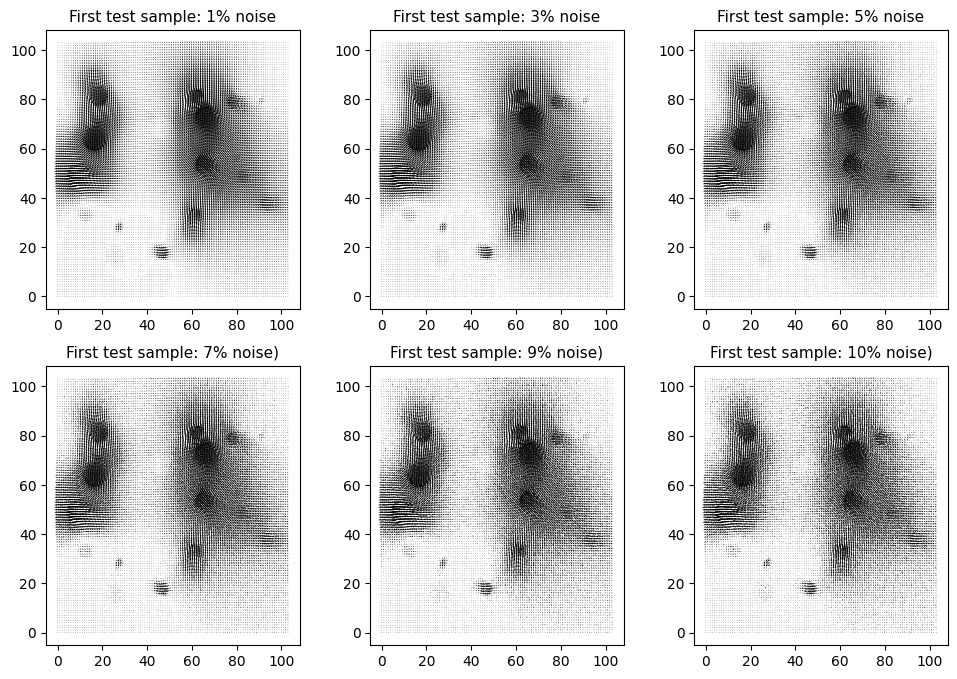

In [228]:
%matplotlib inline

fig, axs = plt.subplots(2, 3, figsize=(10, 7))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(test_sets['1'][0, 0, :, :], test_sets['1'][0, 1, :, :], scale=1)
axs[0, 0].set_title('First test sample: 1% noise', {'fontsize': 11})

axs[0, 1].quiver(test_sets['3'][0, 0, :, :], test_sets['3'][0, 1, :, :], scale=1)
axs[0, 1].set_title('First test sample: 3% noise', {'fontsize': 11})

axs[0, 2].quiver(test_sets['5'][0, 0, :, :], test_sets['5'][0, 1, :, :], scale=1)
axs[0, 2].set_title(f'First test sample: 5% noise', {'fontsize': 11})

axs[1, 0].quiver(test_sets['7'][0, 0, :, :], test_sets['7'][0, 1, :, :], scale=1)
axs[1, 0].set_title(f'First test sample: 7% noise)', {'fontsize': 11})

axs[1, 1].quiver(test_sets['9'][0, 0, :, :], test_sets['9'][0, 1, :, :], scale=1)
axs[1, 1].set_title(f'First test sample: 9% noise)', {'fontsize': 11})

axs[1, 2].quiver(test_sets['10'][0, 0, :, :], test_sets['10'][0, 1, :, :], scale=1)
axs[1, 2].set_title(f'First test sample: 10% noise)', {'fontsize': 11})

In [229]:
print(f'Gaussian noise variance used for training the ViT and CNN: {1.2998083548154682e-07}')

Gaussian noise variance used for training the ViT and CNN: 1.2998083548154682e-07


In [230]:
for i in range(1,11):
    print(f'{i}. Gaussian noise variance for testing the first sample is {((i/100) * std_dspl[1] ** 2)}')

1. Gaussian noise variance for testing the first sample is 2.896900672694561e-07
2. Gaussian noise variance for testing the first sample is 5.793801345389122e-07
3. Gaussian noise variance for testing the first sample is 8.690702018083682e-07
4. Gaussian noise variance for testing the first sample is 1.1587602690778243e-06
5. Gaussian noise variance for testing the first sample is 1.4484503363472804e-06
6. Gaussian noise variance for testing the first sample is 1.7381404036167364e-06
7. Gaussian noise variance for testing the first sample is 2.0278304708861926e-06
8. Gaussian noise variance for testing the first sample is 2.3175205381556487e-06
9. Gaussian noise variance for testing the first sample is 2.6072106054251043e-06
10. Gaussian noise variance for testing the first sample is 2.8969006726945607e-06


Predictions by ViT and CNN for test sample.

Export test sets to mat files.

In [29]:
import shutil

save_files_here = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data/Raw Samples'
xx, yy = np.meshgrid(np.arange(104), np.arange(104), indexing='ij')
pos = np.vstack([xx.reshape(-1), yy.reshape(-1)], dtype=np.double).T
for i in range(1, 11):
    path_to_dir = f'{save_files_here}/{i}'
    if os.path.exists(path_to_dir):
        shutil.rmtree(path_to_dir)
    os.makedirs(path_to_dir)
    for j, sample in enumerate(test_sets[f'{i}']):
        file_name = f'{path_to_dir}/test_sample_{j + 1}.mat'
        vec_dspl = np.vstack([sample[0].reshape(-1), sample[1].reshape(-1)], dtype=np.double).T
        vec_noise = np.vstack([noise_sets[f'{i}'][j, 0].reshape(-1), noise_sets[f'{i}'][j, 1].reshape(-1)], dtype=np.double).T
        mdict = {'input_data': {'noise': [{'vec': vec_noise, 'pos': pos}, {'vec': vec_noise, 'pos': pos}], 'displacement': [{'vec': vec_dspl, 'pos': pos}, {'vec': vec_dspl, 'pos': pos}]}}
        savemat(file_name, mdict=mdict)

TypeError: _vhstack_dispatcher() got an unexpected keyword argument 'dtype'

Load BFFTC predictions for each test set.

In [231]:
bfftc_prediction_sets = {}
bfftc_displacement_sets = {}

directory = "/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Artificial patch data/Predictions"
    
for i, _ in enumerate(os.listdir(directory), 1):
    bfftc_prediction = np.zeros((Y_test.shape[0], 2, 102, 102))
    bfftc_displacement = np.zeros((Y_test.shape[0], 2, 102, 102))
    for j, file in enumerate(os.listdir(f'{directory}/{i}')):
        filename = os.fsdecode(file)
        if filename.endswith(".mat"):
            bfft_pred = loadmat(f'{directory}/{i}/{filename}')['TFM_results']['traction'][0][0].T.reshape((2, 102, 102), order='F')
            bfft_dspl = loadmat(f'{directory}/{i}/{filename}')['TFM_results']['displacement'][0][0].T.reshape((2, 102, 102), order='F')
            bfftc_prediction[j] = bfft_pred
            bfftc_displacement[j] = bfft_dspl
    bfftc_prediction_sets[f'{i}'] = bfftc_prediction
    bfftc_displacement_sets[f'{i}'] = bfftc_displacement

Find correct samples in test set and remove outer rims.

In [232]:
bfftc_prediction_sets_trimmed = {}
ground_truth_sets_trimmed = {}
noisy_X_test_sets = {}

for num, pred in tqdm(bfftc_prediction_sets.items()):
    bfftc_prediction_set_trimmed = torch.zeros((test_sets[num].shape[0], test_sets[num].shape[1], 98, 98))
    ground_truths_trimmed = torch.zeros((test_sets[num].shape[0], 3, 98, 98))
    X_test_noisy = torch.zeros(test_sets[num].shape)
    for i, sample in enumerate(bfftc_displacement_sets[num]):
        for j, dspl in enumerate(torch.tensor(test_sets[num])):
            if torch.allclose(dspl[:, 1:103, 1:103].float(), torch.tensor(sample).float(), atol=1e-02, rtol=1):
                bfftc_prediction_set_trimmed[i] = torch.tensor(bfftc_prediction_sets[num][i, :, 3:101, 3:101]).float()
                ground_truths_trimmed[i] = Y_test[j, :, 3:101, 3:101].float()
                X_test_noisy[i] = dspl.float()
    bfftc_prediction_sets_trimmed[num] = bfftc_prediction_set_trimmed
    ground_truth_sets_trimmed[num] = ground_truths_trimmed
    noisy_X_test_sets[num] = X_test_noisy

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


In [234]:
vit.eval()
vit_predictions = {}
cnn_predictions = {}
for num, test_set in noisy_X_test_sets.items():
    vit_predictions[num] = vit(torch.tensor(test_set).float())
    cnn_predictions[num] = cnn.predict(np.moveaxis(np.array(test_set), 1, 3))

4/4 [==============================] - 0s 40ms/step


Text(0.5, 1.0, 'BFFTC Pred: 10% noise (loss:  0.001353)')

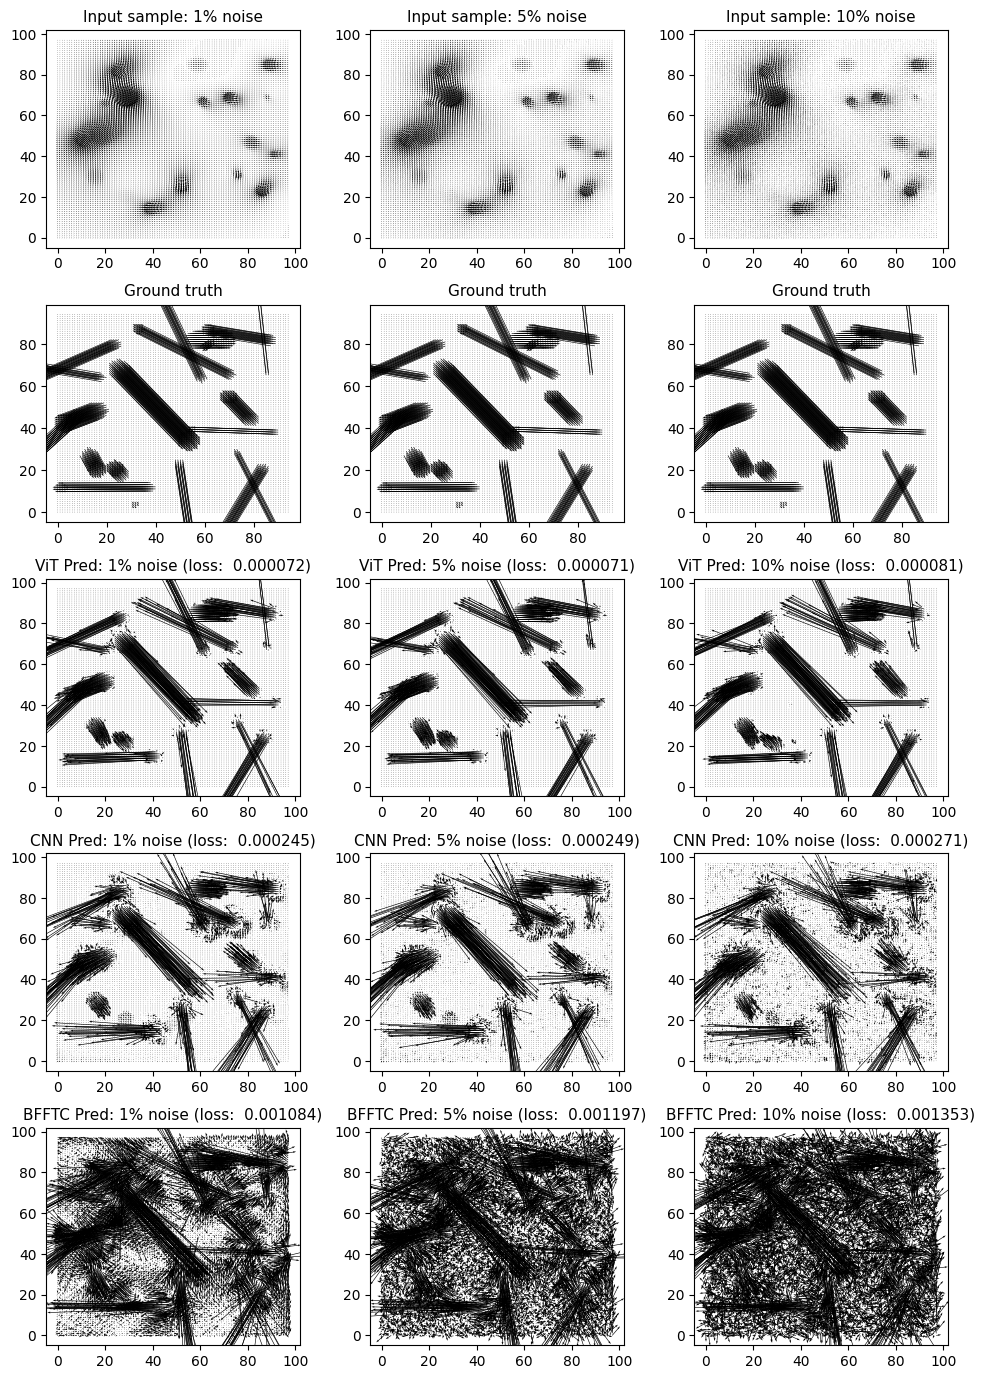

In [235]:
%matplotlib inline

fig, axs = plt.subplots(5, 3, figsize=(10, 14))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)
mse = torch.nn.MSELoss(reduction='none')

axs[0, 0].quiver(noisy_X_test_sets['1'][0, 0, 3:101, 3:101], noisy_X_test_sets['1'][0, 1, 3:101, 3:101], scale=1)
axs[0, 0].set_title(f'Input sample: 1% noise', {'fontsize': 11})

axs[0, 1].quiver(noisy_X_test_sets['5'][0, 0, 3:101, 3:101], noisy_X_test_sets['5'][0, 1, 3:101, 3:101], scale=1)
axs[0, 1].set_title(f'Input sample: 5% noise', {'fontsize': 11})

axs[0, 2].quiver(noisy_X_test_sets['10'][0, 0, 3:101, 3:101], noisy_X_test_sets['10'][0, 1, 3:101, 3:101], scale=1)
axs[0, 2].set_title(f'Input sample: 10% noise', {'fontsize': 11})

axs[1, 0].quiver(ground_truth_sets_trimmed['1'][0, 0, 3:101, 3:101], ground_truth_sets_trimmed['1'][0, 1, 3:101, 3:101], scale=1)
axs[1, 0].set_title(f'Ground truth', {'fontsize': 11})

axs[1, 1].quiver(ground_truth_sets_trimmed['5'][0, 0, 3:101, 3:101], ground_truth_sets_trimmed['5'][0, 1, 3:101, 3:101], scale=1)
axs[1, 1].set_title(f'Ground truth', {'fontsize': 11})

axs[1, 2].quiver(ground_truth_sets_trimmed['10'][0, 0, 3:101, 3:101], ground_truth_sets_trimmed['10'][0, 1, 3:101, 3:101], scale=1)
axs[1, 2].set_title(f'Ground truth', {'fontsize': 11})

axs[2, 0].quiver(vit_predictions['1'][0, 0, 3:101, 3:101].detach().numpy(), vit_predictions['1'][0, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[2, 0].set_title(f'ViT Pred: 1% noise (loss: {torch.mean(mse(vit_predictions["1"][0, :, 3:101, 3:101].unsqueeze(dim=0), ground_truth_sets_trimmed["1"][0, 0:2].unsqueeze(dim=0))):9.6f})', {'fontsize': 11})

axs[2, 1].quiver(vit_predictions['5'][0, 0, 3:101, 3:101].detach().numpy(), vit_predictions['5'][0, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[2, 1].set_title(f'ViT Pred: 5% noise (loss: {torch.mean(mse(vit_predictions["5"][0, :, 3:101, 3:101].unsqueeze(dim=0), ground_truth_sets_trimmed["5"][0, 0:2].unsqueeze(dim=0))):9.6f})', {'fontsize': 11})

axs[2, 2].quiver(vit_predictions['10'][0, 0, 3:101, 3:101].detach().numpy(), vit_predictions['10'][0, 1, 3:101, 3:101].detach().numpy(), scale=1)
axs[2, 2].set_title(f'ViT Pred: 10% noise (loss: {torch.mean(mse(vit_predictions["10"][0, :, 3:101, 3:101].unsqueeze(dim=0), ground_truth_sets_trimmed["10"][0, 0:2].unsqueeze(dim=0))):9.6f})', {'fontsize': 11})

axs[3, 0].quiver(cnn_predictions['1'][0, 3:101, 3:101, 0], cnn_predictions['1'][0, 3:101, 3:101, 1], scale=1)
axs[3, 0].set_title(f'CNN Pred: 1% noise (loss: {torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions["1"], 3, 1)[0, :, 3:101, 3:101]), ground_truth_sets_trimmed["1"][0, 0:2].unsqueeze(dim=0))):9.6f})', {'fontsize': 11})

axs[3, 1].quiver(cnn_predictions['5'][0, 3:101, 3:101, 0], cnn_predictions['5'][0, 3:101, 3:101, 1], scale=1)
axs[3, 1].set_title(f'CNN Pred: 5% noise (loss: {torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions["5"], 3, 1)[0, :, 3:101, 3:101]), ground_truth_sets_trimmed["5"][0, 0:2].unsqueeze(dim=0))):9.6f})', {'fontsize': 11})

axs[3, 2].quiver(cnn_predictions['10'][0,3:101, 3:101, 0], cnn_predictions['10'][0, 3:101, 3:101, 1], scale=1)
axs[3, 2].set_title(f'CNN Pred: 10% noise (loss: {torch.mean(mse(torch.tensor(np.moveaxis(cnn_predictions["10"], 3, 1)[0, :, 3:101, 3:101]), ground_truth_sets_trimmed["10"][0, 0:2].unsqueeze(dim=0))):9.6f})', {'fontsize': 11})

axs[4, 0].quiver(bfftc_prediction_sets_trimmed['1'][0, 0], bfftc_prediction_sets_trimmed['1'][0, 1], scale=1)
axs[4, 0].set_title(f'BFFTC Pred: 1% noise (loss: {torch.mean(mse(torch.tensor(bfftc_prediction_sets_trimmed["1"][0]), ground_truth_sets_trimmed["1"][0, 0:2])):9.6f})', {'fontsize': 11})

axs[4, 1].quiver(bfftc_prediction_sets_trimmed['5'][0, 0], bfftc_prediction_sets_trimmed['5'][0, 1], scale=1)
axs[4, 1].set_title(f'BFFTC Pred: 5% noise (loss: {torch.mean(mse(torch.tensor(bfftc_prediction_sets_trimmed["5"][0]), ground_truth_sets_trimmed["5"][0, 0:2])):9.6f})', {'fontsize': 11})

axs[4, 2].quiver(bfftc_prediction_sets_trimmed['10'][0, 0], bfftc_prediction_sets_trimmed['10'][0, 1], scale=1)
axs[4, 2].set_title(f'BFFTC Pred: 10% noise (loss: {torch.mean(mse(torch.tensor(bfftc_prediction_sets_trimmed["10"][0]), ground_truth_sets_trimmed["10"][0, 0:2])):9.6f})', {'fontsize': 11})

In [123]:
levels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
metrics = ['mse', 'dtma', 'dtmb', 'snr', 'cos_sim', 'adtma']

vit_mses = []
cnn_mses = []
bfftc_mses = []

vit_cos_sims = []
cnn_cos_sims = []
bfftc_cos_sims = []

vit_dtmbs = []
cnn_dtmbs = []
bfftc_dtmbs = []

vit_dtmas = []
cnn_dtmas = []
bfftc_dtmas = []

vit_adtmas = []
cnn_adtmas = []
bfftc_adtmas = []

vit_snrs = []
cnn_snrs = []
bfftc_snrs = []

vit_dmas = []
cnn_dmas = []
bfftc_dmas = []

In [124]:
def compute_mse_for_noise_level(vit_prediction, cnn_prediction, bfftc_prediction_set_trimmed, ground_truth_set_trimmed):
    mse = torch.nn.MSELoss(reduction='none')
    vit_mse = torch.mean(mse(vit_prediction[:, :, 3:101, 3:101], ground_truth_set_trimmed[:, 0:2]))
    cnn_mse = torch.mean(mse(torch.tensor(np.moveaxis(cnn_prediction, 3, 1)[:, :, 3:101, 3:101]), ground_truth_set_trimmed[:, 0:2]))
    bfftc_mse = torch.mean(mse(bfftc_prediction_set_trimmed, ground_truth_set_trimmed[:, 0:2]))
    
    return vit_mse, cnn_mse, bfftc_mse

In [125]:
def compute_cosine_sim_for_noise_level(appended_vit_prediction, appended_cnn_prediction, appended_bfftc_prediction, appended_vit_target, appended_cnn_target, appended_bfftc_target):
    vit_cos_sim = cosine_sim(appended_vit_prediction, appended_vit_target, device, False)
    cnn_cos_sim = cosine_sim(appended_cnn_prediction, appended_cnn_target, device, False)
    bfftc_cos_sim = cosine_sim(appended_bfftc_prediction, appended_bfftc_target, device, False)
    
    return vit_cos_sim, cnn_cos_sim, bfftc_cos_sim

In [126]:
def compute_dtmb_for_noise_level(vit_predictions, cnn_predictions, bfftc_prediction_set_trimmed, ground_truth_set_trimmed, appended_vit_target, appended_cnn_target, appended_bfftc_target):
    vit_dtmb = dtmb(vit_predictions[:, :, 3:101, 3:101], ground_truth_set_trimmed, appended_vit_target, device, False)
    cnn_dtmb = dtmb(torch.tensor(np.moveaxis(cnn_predictions, 3, 1))[:, :, 3:101, 3:101], ground_truth_set_trimmed, appended_cnn_target, device, False)
    bfftc_dtmb = dtmb(bfftc_prediction_set_trimmed, ground_truth_set_trimmed, appended_bfftc_target, device, False)

    return vit_dtmb, cnn_dtmb, bfftc_dtmb

In [127]:
def compute_dtma_for_noise_level(appended_vit_prediction, appended_cnn_prediction, appended_bfftc_prediction, appended_vit_target, appended_cnn_target, appended_bfftc_target):     
    vit_dtma = dtma(appended_vit_prediction, appended_vit_target, device, False)
    cnn_dtma = dtma(appended_cnn_prediction, appended_cnn_target, device, False)
    bfftc_dtma = dtma(appended_bfftc_prediction, appended_bfftc_target, device, False)
    
    return vit_dtma, cnn_dtma, bfftc_dtma

In [128]:
def compute_adtma_for_noise_level(appended_vit_prediction, appended_vit_target, appended_cnn_prediction, appended_cnn_target, appended_bfftc_prediction, appended_bfftc_target):
    vit_adtma = adtma(appended_vit_prediction, appended_vit_target, device, False)
    cnn_adtma = adtma(appended_cnn_prediction, appended_cnn_target, device, False)
    bfftc_adtma = adtma(appended_bfftc_prediction, appended_bfftc_target, device, False)
    
    return vit_adtma, cnn_adtma, bfftc_adtma

In [129]:
def compute_snr_for_noise_level(vit_prediction, vit_target, appended_vit_target, cnn_prediction, cnn_target, appended_cnn_target, bfftc_prediction, bfftc_target, appended_bfftc_target ):
    vit_snr = snr(vit_prediction[:, :, 3:101, 3:101], vit_target, appended_vit_target, device, False)
    cnn_snr = snr(torch.tensor(np.moveaxis(cnn_prediction, 3, 1))[:, :, 3:101, 3:101], cnn_target, appended_cnn_target, device, False)
    bfftc_snr = snr(bfftc_prediction, bfftc_target, appended_bfftc_target, device, False)
    
    return vit_snr, cnn_snr, bfftc_snr

In [130]:
def compute_dma_for_noise_level(vit_target, appended_vit_prediction, appended_vit_target, cnn_target, appended_cnn_prediction, appended_cnn_target, bfftc_target, appended_bfftc_prediction, appended_bfftc_target):
    vit_dma = dma(vit_target, appended_vit_prediction, appended_vit_target, device, False)
    cnn_dma = dma(cnn_target, appended_cnn_prediction, appended_cnn_target, device, False)
    bfftc_dma = dma(bfftc_target, appended_bfftc_prediction, appended_bfftc_target, device, False)
    
    return vit_dma, cnn_dma, bfftc_dma

In [87]:
from MultiTask import append_predictions_and_targets, cosine_sim, adtma, dtma, dma, snr, dtmb

for noise_level in tqdm(levels):
    appended_vit_predictions, appended_vit_targets = append_predictions_and_targets(vit_predictions[noise_level][:, :, 3:101, 3:101], ground_truth_sets_trimmed[noise_level], device)
    appended_cnn_predictions, appended_cnn_targets = append_predictions_and_targets(torch.tensor(np.moveaxis(cnn_predictions[noise_level], 3, 1))[:, :, 3:101, 3:101], ground_truth_sets_trimmed[noise_level], device)
    appended_bfftc_predictions, appended_bfftc_targets = append_predictions_and_targets(bfftc_prediction_sets_trimmed[noise_level], ground_truth_sets_trimmed[noise_level], device)
    # mse
    vit_mse, cnn_mse, bfftc_mse = compute_mse_for_noise_level(vit_predictions[noise_level], cnn_predictions[noise_level], bfftc_prediction_sets_trimmed[noise_level], ground_truth_sets_trimmed[noise_level])
    vit_mses.append(vit_mse.detach())
    cnn_mses.append(cnn_mse.detach())
    bfftc_mses.append(bfftc_mse.detach())
    # cos_sim
    vit_cos_sim, cnn_cos_sim, bfftc_cos_sim = compute_cosine_sim_for_noise_level(
        appended_vit_predictions,
        appended_cnn_predictions,
        appended_bfftc_predictions,
        appended_vit_targets,
        appended_cnn_targets,
        appended_bfftc_targets)
    vit_cos_sims.append(vit_cos_sim.detach())
    cnn_cos_sims.append(cnn_cos_sim.detach())
    bfftc_cos_sims.append(bfftc_cos_sim.detach())
    # dtma
    vit_dtma, cnn_dtma, bfftc_dtma = compute_dtma_for_noise_level(
        appended_vit_predictions, 
        appended_cnn_predictions, 
        appended_bfftc_predictions, 
        appended_vit_targets,
        appended_cnn_targets, 
        appended_bfftc_targets)
    vit_dtmas.append(vit_dtma.detach())
    cnn_dtmas.append(cnn_dtma.detach())
    bfftc_dtmas.append(bfftc_dtma.detach())
    # dtmb
    vit_dtmb, cnn_dtmb, bfftc_dtmb = compute_dtmb_for_noise_level(
        vit_predictions[noise_level], 
        cnn_predictions[noise_level], 
        bfftc_prediction_sets_trimmed[noise_level],
        ground_truth_sets_trimmed[noise_level],
        appended_vit_targets,
        appended_cnn_targets, 
        appended_bfftc_targets)
    vit_dtmbs.append(vit_dtmb.detach())
    cnn_dtmbs.append(cnn_dtmb.detach())
    bfftc_dtmbs.append(bfftc_dtmb.detach())
    # adtma
    vit_adtma, cnn_adtma, bfftc_adtma = compute_adtma_for_noise_level(
        appended_vit_predictions, 
        appended_vit_targets, 
        appended_cnn_predictions, 
        appended_cnn_targets,
        appended_bfftc_predictions, 
        appended_bfftc_targets)
    vit_adtmas.append(vit_adtma.detach())
    cnn_adtmas.append(cnn_adtma.detach())
    bfftc_adtmas.append(bfftc_adtma.detach())
    # snr
    vit_snr, cnn_snr, bfftc_snr = compute_snr_for_noise_level(
        vit_predictions[noise_level],
        ground_truth_sets_trimmed[noise_level],
        appended_vit_targets,
        cnn_predictions[noise_level],
        ground_truth_sets_trimmed[noise_level],
        appended_cnn_targets,
        bfftc_prediction_sets_trimmed[noise_level],
        ground_truth_sets_trimmed[noise_level],
        appended_bfftc_targets)
    vit_snrs.append(vit_snr.detach())
    cnn_snrs.append(cnn_snr.detach())
    bfftc_snrs.append(bfftc_snr.detach())
    # dma
    vit_dma, cnn_dma, bfftc_dma = compute_dma_for_noise_level(
        ground_truth_sets_trimmed[noise_level],
        appended_vit_predictions, 
        appended_vit_targets,
        ground_truth_sets_trimmed[noise_level],
        appended_cnn_predictions, 
        appended_cnn_targets,
        ground_truth_sets_trimmed[noise_level],
        appended_bfftc_predictions,
        appended_bfftc_targets)
    vit_dmas.append(vit_dma.detach())
    cnn_dmas.append(cnn_dma.detach())
    bfftc_dmas.append(bfftc_dma.detach())

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [31:36<00:00, 189.62s/it]


In [88]:
x = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

Text(0.5, 1.0, '0  MSE')

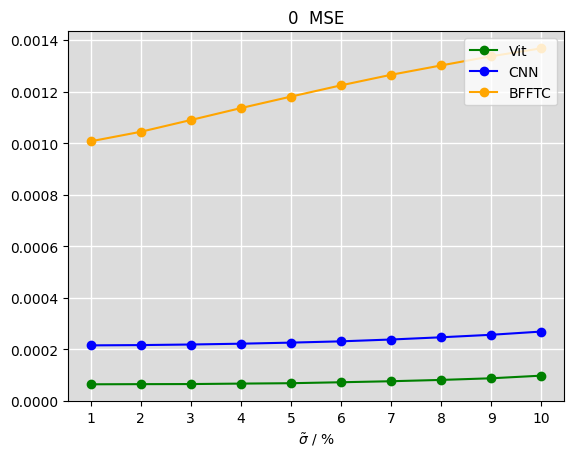

In [89]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, [mse.detach().numpy() for mse in vit_mses], 'o-', color='green', label='Vit')
plt.plot(x, [mse.detach().numpy() for mse in cnn_mses], 'o-', color='blue', label='CNN')
plt.plot(x, [mse.detach().numpy() for mse in bfftc_mses], 'o-', color='orange', label='BFFTC')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('0  MSE', )

Text(0.5, 1.0, '1  Cos sim')

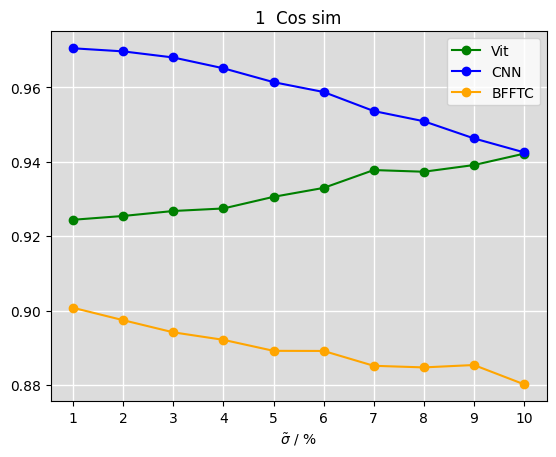

In [90]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, [sim.detach().numpy() for sim in vit_cos_sims], 'o-', color='green', label='Vit')
plt.plot(x, [sim.detach().numpy() for sim in cnn_cos_sims], 'o-', color='blue', label='CNN')
plt.plot(x, [sim.detach().numpy() for sim in bfftc_cos_sims], 'o-', color='orange', label='BFFTC')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('1  Cos sim', )

Text(0.5, 1.0, '0  DTMA')

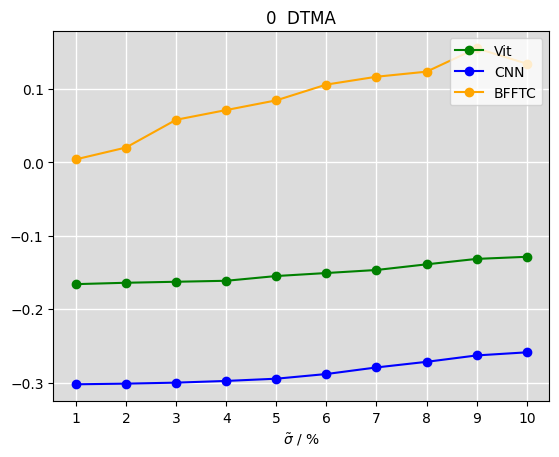

In [91]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, [dtma.detach().numpy() for dtma in vit_dtmas], 'o-', color='green', label='Vit')
plt.plot(x, [dtma.detach().numpy() for dtma in cnn_dtmas], 'o-', color='blue', label='CNN')
plt.plot(x, [dtma.detach().numpy() for dtma in bfftc_dtmas], 'o-', color='orange', label='BFFTC')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('0  DTMA', )

Text(0.5, 1.0, '0  DTMB')

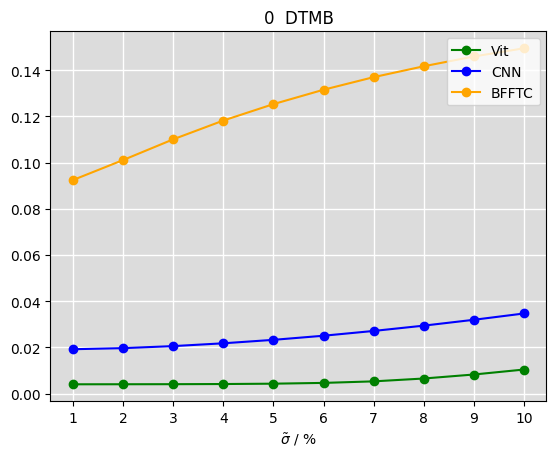

In [92]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, [dtmb.detach().numpy() for dtmb in vit_dtmbs], 'o-', color='green', label='Vit')
plt.plot(x, [dtmb.detach().numpy() for dtmb in cnn_dtmbs], 'o-', color='blue', label='CNN')
plt.plot(x, [dtmb.detach().numpy() for dtmb in bfftc_dtmbs], 'o-', color='orange', label='BFFTC')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('0  DTMB', )

Text(0.5, 1.0, '0  ADTMA')

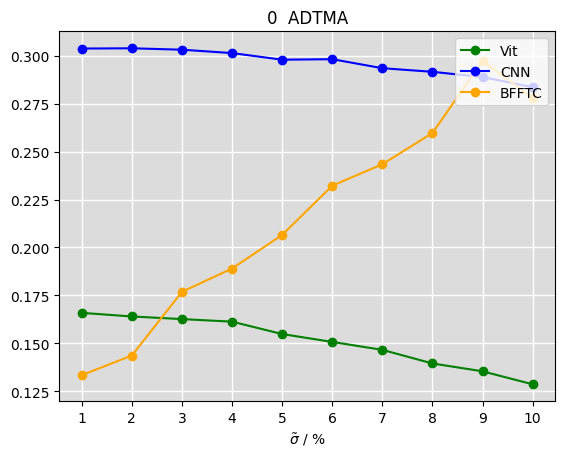

In [93]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, [adtma.detach().numpy() for adtma in vit_adtmas], 'o-', color='green', label='Vit')
plt.plot(x, [adtma.detach().numpy() for adtma in cnn_adtmas], 'o-', color='blue', label='CNN')
plt.plot(x, [adtma.detach().numpy() for adtma in bfftc_adtmas], 'o-', color='orange', label='BFFTC')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('0  ADTMA', )

Text(0.5, 1.0, '0  DMA')

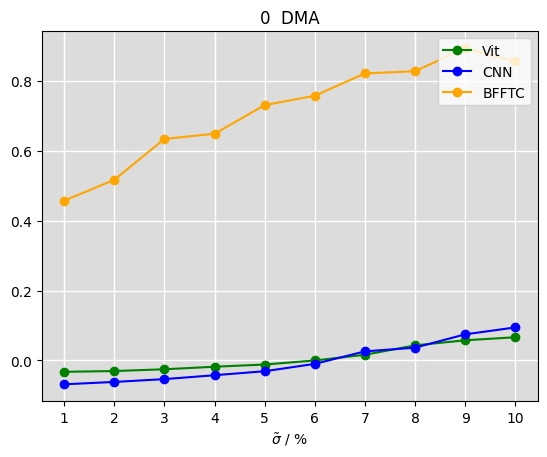

In [94]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, [dma.detach().numpy() for dma in vit_dmas], 'o-', color='green', label='Vit')
plt.plot(x, [dma.detach().numpy() for dma in cnn_dmas], 'o-', color='blue', label='CNN')
plt.plot(x, [dma.detach().numpy() for dma in bfftc_dmas], 'o-', color='orange', label='BFFTC')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('0  DMA', )

Text(0.5, 1.0, 'SNR')

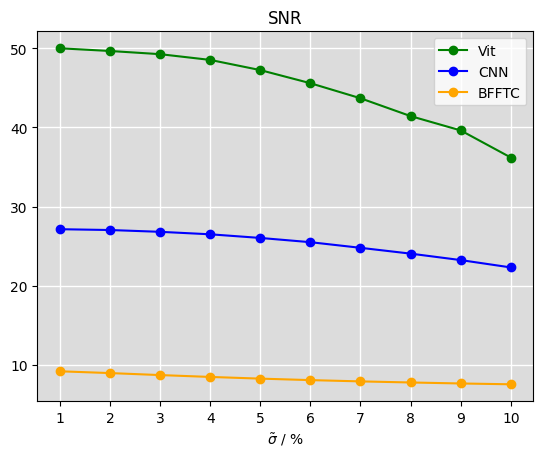

In [95]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, [snr.detach().numpy() for snr in vit_snrs], 'o-', color='green', label='Vit')
plt.plot(x, [snr.detach().numpy() for snr in cnn_snrs], 'o-', color='blue', label='CNN')
plt.plot(x, [snr.detach().numpy() for snr in bfftc_snrs], 'o-', color='orange', label='BFFTC')
plt.legend(loc="upper right")
ax.set_facecolor('gainsboro')
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_xlabel(r'$\mathit{\tilde\sigma}$ / %')
plt.title('SNR', )

Compute MSE, DTMA and DDA for the predictions.

In [ ]:
vit_new.eval()
pred_vit_new = vit_new(X_test_noisy, device=device)
pred_cnn = cnn.predict(np.moveaxis(np.array(X_test_noisy), 1, 3))

In [ ]:
from MultiTask import append_predictions_and_targets, cosine_sim, adtma, dtma, dma, snr, dtmb

mse = torch.nn.MSELoss(reduction='none')
mse_vit_new = torch.mean(mse(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed[:, 0:2]), (1, 2, 3))
mse_cnn = torch.mean(mse(torch.tensor(np.moveaxis(pred_cnn, 3, 1)[:, :, 3:101, 3:101]), ground_truths_trimmed[:, 0:2]), (1, 2, 3))
mse_bfftc = torch.mean(mse(bfftc_predictions_trimmed, ground_truths_trimmed[:, 0:2]), (1, 2, 3))

mse_vit_new = torch.reshape(mse_vit_new, (ground_truths_trimmed.shape[0], 1))
mse_cnn = torch.reshape(mse_cnn, (ground_truths_trimmed.shape[0], 1))
mse_bfftc = torch.reshape(mse_bfftc, (ground_truths_trimmed.shape[0], 1))

In [ ]:
appended_vit_predictions, appended_vit_targets = append_predictions_and_targets(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed, device)
dtma_vit_new = dtma(appended_vit_predictions, appended_vit_targets, device, True)
dtmb_vit_new = dtmb(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed, appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
snr_vit_new = snr(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed, appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
dma_vit_new = dma(pred_vit_new[:, :, 3:101, 3:101], ground_truths_trimmed, appended_vit_predictions, appended_vit_targets, device=device, per_sample=True)
adtma_vit_new = adtma(appended_vit_predictions, appended_vit_targets, device, True)

In [ ]:
cosine_sim_vit_new = cosine_sim(appended_vit_predictions, appended_vit_targets, device, True)

In [ ]:
appended_cnn_predictions, appended_cnn_targets = append_predictions_and_targets(torch.tensor(np.moveaxis(pred_cnn, 3, 1))[:, :, 3:101, 3:101], ground_truths_trimmed, device)
dtma_cnn = dtma(appended_cnn_predictions, appended_cnn_targets, device, True)
dtmb_cnn = dtmb(torch.tensor(np.moveaxis(pred_cnn, 3, 1))[:, :, 3:101, 3:101], ground_truths_trimmed, appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
snr_cnn = snr(torch.tensor(np.moveaxis(pred_cnn, 3, 1))[:, :, 3:101, 3:101], ground_truths_trimmed, appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
dma_cnn = dma(torch.tensor(np.moveaxis(pred_cnn, 3, 1))[:, :, 3:101, 3:101], ground_truths_trimmed, appended_cnn_predictions, appended_cnn_targets, device=device, per_sample=True)
adtma_cnn = adtma(appended_cnn_predictions, appended_cnn_targets, device, True)

In [ ]:
cosine_cnn = cosine_sim(appended_cnn_predictions, appended_cnn_targets, device, True)

In [ ]:
appended_bfftc_predictions, appended_bfftc_targets = append_predictions_and_targets(bfftc_predictions_trimmed, ground_truths_trimmed, device)
dtma_bfftc = dtma(appended_bfftc_predictions, appended_bfftc_targets, device, True)
dda_bfftc = dda(appended_bfftc_predictions, appended_bfftc_targets, device, True)
dtmb_bfftc = dtmb(bfftc_predictions_trimmed, ground_truths_trimmed, appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
snr_bfftc = snr(bfftc_predictions_trimmed, ground_truths_trimmed, appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
dma_bfftc = dma(bfftc_predictions_trimmed, ground_truths_trimmed, appended_bfftc_predictions, appended_bfftc_targets, device=device, per_sample=True)
adtma_bfftc = adtma(appended_bfftc_predictions, appended_bfftc_targets, device, True)

In [ ]:
cosine_bfftc = cosine_sim(appended_bfftc_predictions, appended_bfftc_targets, device, True)

In [ ]:
dtma_vit_new = torch.reshape(dtma_vit_new, (ground_truths_trimmed.shape[0], 1))
dtma_cnn = torch.reshape(dtma_cnn, (ground_truths_trimmed.shape[0], 1))
dtma_bfftc = torch.reshape(dtma_bfftc, (ground_truths_trimmed.shape[0], 1))

cosine_sim_vit_new = torch.reshape(cosine_sim_vit_new, (ground_truths_trimmed.shape[0], 1))
cosine_cnn = torch.reshape(cosine_cnn, (ground_truths_trimmed.shape[0], 1))
cosine_bfftc = torch.reshape(cosine_bfftc, (ground_truths_trimmed.shape[0], 1))

dtmb_vit_new = torch.reshape(dtmb_vit_new, (ground_truths_trimmed.shape[0], 1))
dtmb_cnn = torch.reshape(dtmb_cnn, (ground_truths_trimmed.shape[0], 1))
dtmb_bfftc = torch.reshape(dtmb_bfftc, (ground_truths_trimmed.shape[0], 1))

snr_vit_new = torch.reshape(snr_vit_new, (ground_truths_trimmed.shape[0], 1))
snr_cnn = torch.reshape(snr_cnn, (ground_truths_trimmed.shape[0], 1))
snr_bfftc = torch.reshape(snr_bfftc, (ground_truths_trimmed.shape[0], 1))

dma_vit_new = torch.reshape(dma_vit_new, (ground_truths_trimmed.shape[0], 1))
dma_cnn = torch.reshape(dma_cnn, (ground_truths_trimmed.shape[0], 1))
dma_bfftc = torch.reshape(dma_bfftc, (ground_truths_trimmed.shape[0], 1))

adtma_vit_new = torch.reshape(adtma_vit_new, (ground_truths_trimmed.shape[0], 1))
adtma_cnn = torch.reshape(adtma_cnn, (ground_truths_trimmed.shape[0], 1))
adtma_bfftc = torch.reshape(adtma_bfftc, (ground_truths_trimmed.shape[0], 1))

In [ ]:
def highlight_closes_to_zero(s, props=''):
    return np.where(np.absolute(s) == np.nanmin(np.absolute(s.values)), props, '')

In [ ]:
def highlight_max(x, props=''):
    return np.where(x == np.nanmax(x.to_numpy()), props, '')

In [ ]:
columns = ['MSE ViT', 
           'MSE CNN',
           'MSE BFFTC',
           'DTMA ViT', 
           'DTMA CNN',
           'DTMA BFFTC',
           'Cosine sim ViT', 
           'Cosine sim CNN',
           'Cosine sim BFFTC',
           'DTMB ViT',
           'DTMB CNN',
           'DTMB BFFTC',
           'SNR ViT',
           'SNR CNN',
           'SNR BFFTC',
           'DMA ViT',
           'DMA CNN',
           'DMA BFFTC',
           'ADTMA ViT',
           'ADTMA CNN',
           'ADTMA BFFTC']

metrics = pd.DataFrame(
    np.array(torch.cat((mse_vit_new, 
                        mse_cnn,
                        mse_bfftc,
                        dtma_vit_new, 
                        dtma_cnn,
                        dtma_bfftc,
                        cosine_sim_vit_new, 
                        cosine_cnn,
                        cosine_bfftc,
                        dtmb_vit_new,
                        dtmb_cnn,
                        dtmb_bfftc,
                        snr_vit_new,
                        snr_cnn,
                        snr_bfftc,
                        dma_vit_new,
                        dma_cnn,
                        dma_bfftc,
                        adtma_vit_new,
                        adtma_cnn,
                        adtma_bfftc
                       ), 1).detach().numpy()), columns=columns)

float_formatter = "{:.6f}".format

averages = {}
for column in columns:
    averages[column] = f"avg: {float_formatter(round(metrics[column].mean(), ndigits=7))}"
    
averages = pd.DataFrame(averages, index=[0])

In [ ]:
metrics
metrics.index += 1 
metrics.loc['mean'] = metrics.mean()
metrics = metrics.tail(32)
slice_ = ['MSE ViT', 'MSE CNN', 'MSE BFFTC']
metrics = metrics.style.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['DTMA ViT', 'DTMA CNN', 'DTMA BFFTC']
metrics = metrics.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['Cosine sim ViT', 'Cosine sim CNN','Cosine sim BFFTC']
metrics = metrics.apply(highlight_max, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['DTMB ViT', 'DTMB CNN','DTMB BFFTC']
metrics = metrics.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['SNR ViT', 'SNR CNN', 'SNR BFFTC']
metrics = metrics.apply(highlight_max, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['DMA ViT', 'DMA CNN', 'DMA BFFTC']
metrics = metrics.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
slice_ = ['ADTMA ViT', 'ADTMA CNN', 'ADTMA BFFTC']
metrics = metrics.apply(highlight_closes_to_zero, props='color:white; background-color:purple', subset=slice_, axis=1)
metrics = metrics.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
metrics.set_properties(**{'text-align': 'center'})

metrics.set_properties(**{"border": "0.5px solid black"})

Plot example cell.

In [ ]:
torch.set_printoptions(sci_mode=False)
torch.set_printoptions(precision=5)

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0, 0].quiver(X_test_noisy_[0, 0, :, :].detach().numpy(), X_test_noisy_[0, 1, :, :].detach().numpy(), scale=1)
axs[0, 0].set_title('Test sample: displacement', {'fontsize': 11})

axs[0, 1].quiver(ground_truths_trimmed[0, 0, :, :].detach().numpy(), ground_truths_trimmed[0, 1, :, :].detach().numpy(), scale=2)
axs[0, 1].set_title('Test sample: traction', {'fontsize': 11})

axs[0, 2].quiver(X_test_noise[0, 0, :, :], X_test_noise[0, 1, :, :], scale=0.05)
axs[0, 2].set_title(f'Test sample: Gaussian noise floor', {'fontsize': 11})

axs[1, 0].quiver(pred_vit_new[0, 0, :, :].detach().numpy(), pred_vit_new[0, 1, :, :].detach().numpy(), scale=1)
axs[1, 0].set_title(f'ViT pred (loss:{mse_vit_new[0, 0]:9.6f})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0, :, :, 0], pred_cnn[0, :, :, 1], scale=1)
axs[1, 1].set_title(f'CNN pred (loss:{mse_cnn[0, 0]:9.6f})', {'fontsize': 11})

axs[1, 2].quiver(bfftc_predictions_trimmed[0, 0, :, :], bfftc_predictions_trimmed[0, 1, :, :], scale=1)
axs[1, 2].set_title(f'BFFTC pred (loss:{mse_bfftc[0, 0]:9.6f})', {'fontsize': 11})

Implementation of DTMB

In [ ]:
Y_test.shape

In [ ]:
appended_multi_targets[0, 2, :, :, :]

Visualize the first test sample, its ground truth and the models' predictions.

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(bfftc_displacements[0, 0, :, :], bfftc_displacements[0, 1, :, :], scale=1)
axs[0, 0].set_title('Displacement field returned by etutfm', {'fontsize': 11})

axs[0, 1].quiver(X_test_noisy[0, 0, :, :].detach().numpy(), X_test_noisy[0, 1, :, :].detach().numpy(), scale=1)
axs[0, 1].set_title(f'Displacement field of X_test_noisy', {'fontsize': 11})

axs[1, 0].quiver(bfftc_predictions_trimmed[0, 0, :, :], bfftc_predictions_trimmed[0, 1, :, :], scale=50)
axs[1, 0].set_title(f'TFM prediction (loss: None)', {'fontsize': 11})

axs[1, 1].quiver(pred_vit_new[0, 0, :, :].detach().numpy(), pred_vit_new[0, 1, :, :].detach().numpy(), scale=1)
axs[1, 1].set_title(f'ViT prediction (loss: {torch.round(mse_vit_new[0, 0], decimals=5)})', {'fontsize': 11})

ym = 0,1 kPa

In [ ]:
path_to_sample_1 = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Bay-FTTC_results_01-02-23.mat'

In [ ]:
bfft_pred = loadmat(path_to_sample_1)['TFM_results']['traction'][0][0].T.reshape((2, 102, 102), order='F')
bfft_dspl = loadmat(path_to_sample_1)['TFM_results']['displacement'][0][0].T.reshape((2, 102, 102), order='F')

In [ ]:
bfft_pred.shape

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(bfft_pred[0, :, :], bfft_pred[1, :, :], scale=0.01)
axs[0].set_title('bfft_pred', {'fontsize': 11})

axs[1].quiver(bfft_dspl[0, :, :], bfft_dspl[1, :, :], scale=1)
axs[1].set_title(f'bfft_dspl', {'fontsize': 11})

ym = 0,01 kPa

In [ ]:
path_to_sample_1 = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/Bay-FTTC_results_01-02-23.mat'
bfft_pred = loadmat(path_to_sample_1)['TFM_results']['traction'][0][0].T.reshape((2, 102, 102), order='F')
bfft_dspl = loadmat(path_to_sample_1)['TFM_results']['displacement'][0][0].T.reshape((2, 102, 102), order='F')

In [ ]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(bfft_pred[0, :, :], bfft_pred[1, :, :], scale=1)
axs[0].set_title('bfft_pred', {'fontsize': 11})

axs[1].quiver(bfft_dspl[0, :, :], bfft_dspl[1, :, :], scale=1)
axs[1].set_title(f'bfft_dspl', {'fontsize': 11})

### Visualization of attention maps

In [ ]:
def compute_attention_map(attn_scores):
    """
    Compute the attention rollout tensors for each layer in a ViT architecture. We assume a batch size of 1.
    
    Parameters
    __________
    attn_scores : List
        List of raw attention tensors for each encoder block.
        
    Returns
    _______
    joint_attentions : List
        List of attention rollouts for each layer.
    
    grid_size : int
        Number of patches per dimension of original (quadratic) input.
    """
    # Stack raw attention tensors in a matrix, get rid of singleton (batch) dimension and average over all attention heads per layer.
    attn_mat = torch.stack(attn_scores) # (depth, n_samples, n_heads, n_patches, n_patches)
    attn_mat = attn_mat.squeeze(1) # (depth, n_heads, n_patches, n_patches)
    attn_mat = torch.mean(attn_mat, dim=1) # (depth, n_heads, n_patches, n_patches)
    
    # Account for skip connections in the architecture
    residual_attn = torch.eye(attn_mat.size(1))
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / aug_attn_mat.sum(dim=-1).unsqueeze(-1)
    
    # Recursively compute attention rollouts 
    joint_attentions = torch.zeros(aug_attn_mat.size())
    joint_attentions[0] = aug_attn_mat[0].double()
    for n in range(1, aug_attn_mat.size(0)):
        joint_attentions[n] = aug_attn_mat[n].double() @ joint_attentions[n-1].double()
    
    grid_size = int(np.sqrt(aug_attn_mat.size(-1)))
    
    return joint_attentions, grid_size

We extract the attention weights of each encoder block for the first test sample and compute the attention rollouts.

In [ ]:
_, attn_scores = vit((X_test[0, :, :, :][np.newaxis, ...]), return_attention=True)
joint_attentions, grid_size = compute_attention_map(attn_scores)

Visualize the test sample and select one patch. We will then track the attention rollout of this patch among the network.

In [ ]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test[0, 0, :, :], X_test[0 ,1 ,: , :], scale=1)
axs[0].set_title('Input as strain map', {'fontsize': 11})

C = np.sqrt(X_test[0, 0, :, :] **2 + X_test[0, 1, :, :] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input as heatmap', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 3 and column == 8:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(8*8, 3*8), width=8, height=8, linewidth=2, color='red', fill=False))

Plot rolled out attention map of chosen patch at each layer of the encoder.

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][47, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 8})
        ind += 1

Next, another test sample with a more "cell-like" geometry is analysed.

In [ ]:
os.chdir('..')
sys.path.append(f"{os.getcwd()}/DL_TFM/scripts/")
from data_preparation import matFiles_to_npArray

In [ ]:
X_test_ = matFiles_to_npArray('comparables/generic')[1]
Y_test_ = matFiles_to_npArray('comparables/generic')[0]
X_test_ = np.moveaxis(np.array(X_test_['dspl'])[np.newaxis, ...], 3, 1)
Y_test_ = np.moveaxis(np.array(Y_test_['trac'])[np.newaxis, ...], 3, 1)

In [ ]:
_, attn_scores = vit(torch.tensor(X_test_).double(), True)
joint_attentions, grid_size = compute_attention_map(attn_scores)

In [ ]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test_[0,0,:,:], X_test_[0,1,:,:], scale=20)
axs[0].set_title('Input (strain vectors)', {'fontsize': 11})

C = np.sqrt(X_test_[0,0,:,:] **2 + X_test_[0,1,:,:] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input (heatmap)', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 7 and column == 9:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(9*8, 7*8), width=8, height=8, linewidth=1, color='red', fill=False))

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][100, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test_[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 10})
        ind += 1

In [ ]:
'''
def allcocate_and_trim(bfftc_prediction_sets, num_processes):
    bfftc_prediction_sets_trimmed = {}
    ground_truth_sets_trimmed = {}
    noisy_X_test_sets_trimmed = {}
    pool = mp.Pool(processes=num_processes)
    for num, pred in bfftc_prediction_sets.items():
        pool.apply_async(one_alloc, args=(num, pred))
    pool.close()
    pool.join()
    
def one_alloc(num, pred):
    bfftc_prediction_set_trimmed = torch.zeros((test_sets[num].shape[0], test_sets[num].shape[1], 98, 98))
    ground_truths_trimmed = torch.zeros((test_sets[num].shape[0], 3, 98, 98))
    X_test_noisy = torch.zeros(test_sets[num].shape)
    for i, sample in tqdm(enumerate(bfftc_displacement_sets[num])):
        for j, dspl in enumerate(torch.tensor(test_sets[num])):
            if torch.allclose(dspl[:, 1:103, 1:103].float(), torch.tensor(sample).float(), atol=1e-02, rtol=1):
                # print(f'Set {num}: sample {i} matches with dspl {j}')
                bfftc_prediction_set_trimmed[i] = torch.tensor(bfftc_prediction_sets[num][i, :, 3:101, 3:101]).float()
                ground_truths_trimmed[i] = Y_test[j, :, 3:101, 3:101].float()
                X_test_noisy[i] = dspl.float()
    bfftc_prediction_sets_trimmed[num] = bfftc_prediction_set_trimmed
    ground_truth_sets_trimmed[num] = ground_truths_trimmed
    noisy_X_test_sets_trimmed[num] = X_test_noisy 
    
'''